# U-Net Ultrasound images Segmentation 

This notebook is a U-Net implementation with TensorFlow 2 / Keras, trained for semantic segmentation on the Breast Cancer Ultrasound Images dataset.

**Reference:**

https://www.kaggle.com/code/youssefelbadry10/breast-cancer-segmentation-acc-97-5

https://github.com/galprz/brain-tumor-segmentation/blob/master/src/models.py


## Table of Contents
>[U-Net Ultrasound images Segmentation](#U-Net-Ultrasound-images-Segmentation)

>>[Table of Contents](#Table-of-Contents)

>>[Setup](#Setup)

>>[Data](#scrollTo=pX631zhEouf4)

>>>[Prepare objects and functions to load data](#Prepare-objects-and-functions-to-load-data)

>>>[Load data](#Load-data)

>>[U-Net building blocks](#U-Net-building-blocks)

>>[Build the U-Net model](#Build-the-U-Net-model)

>>[Compile and train the model](#Compile-and-train-the-model)

>>[Plot the loss and accuracy curves from model history](#Plot-the-loss-and-accuracy-curves-from-model-history)

>>[Predictions with the trained model](#Predictions-with-the-trained-model)


## Setup

In [1]:
# Standard Libraries
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Scikit-learn
from sklearn.metrics import confusion_matrix
# Keras
from keras import Sequential, Model
from keras.layers import (Input, Conv2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, MaxPooling2D,AveragePooling2D, Dropout, Dense, Flatten)
from keras.callbacks import EarlyStopping
from keras.metrics import MeanIoU
import tensorflow as tf

## Data

### Prepare objects and functions to load data

In [2]:
# Objects to hold pairs of images and masks
train_image_mask = {
    'images': [],
    'masks': []
}

test_image_mask = {
    'images': [],
    'masks': []
}

valid_image_mask = {
    'images': [],
    'masks': []
}

# Objects to hold pairs of images and labels
train_image_class = {
    'images': [],
    'labels': []
}

test_image_class = {
    'images': [],
    'labels': []
}

def load_image_mask(train_image_mask=None, valid_image_mask=None, test_image_mask=None, image_path=None, shape=256):
    """Generates image/mask pairs from the dataset.

    Args:
        train_image_mask (dict): Dictionary to store training images and masks.
        test_image_mask (dict): Dictionary to store testing images and masks.
        image_path (str): Path to the images and masks.
        shape (int): Size to resize images and masks.

    Returns:
        tuple: Updated dictionaries containing images and masks.
    """
    file_names = os.listdir(image_path)
    
    image_names = []
    mask_names = []
    partial_names = [fn.split(')')[0] for fn in file_names]
    
    partial_names = list(set(partial_names))
    
    for name in partial_names:
        image_names.append(name + ').png')
        mask_names.append(name + ')_mask.png')
        
    train_test_split_index = int(len(image_names) * 0.8)
    train_valid_split_index = int(len(image_names) * 0.7)
    
    for i, image_name in enumerate(image_names):
        image = plt.imread(os.path.join(image_path, image_name))
        mask = plt.imread(os.path.join(image_path, mask_names[i]))
        
        image = cv2.resize(image, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))
        
        
        if i < train_test_split_index:
            if i < train_valid_split_index:
                train_image_mask['images'].append(image)
                train_image_mask['masks'].append(mask)
            else:
                valid_image_mask['images'].append(image)
                valid_image_mask['masks'].append(mask)
        else:
            test_image_mask['images'].append(image)
            test_image_mask['masks'].append(mask)
        
    return train_image_mask, valid_image_mask, test_image_mask

def load_image_class(train_image_class=None, test_image_class=None, image_path=None, shape=256):
    """Generates image/label pairs from the dataset.

    Args:
        train_image_class (dict): Dictionary to store training images and labels.
        test_image_class (dict): Dictionary to store testing images and labels.
        image_path (str): Path to the images.
        shape (int): Size to resize images.

    Returns:
        tuple: Updated dictionaries containing images and labels.
    """
    file_names = os.listdir(image_path)
    image_class = os.path.basename(image_path)
    
    image_names = [fn.split(')')[0] + ').png' for fn in file_names]
    
    train_test_split_index = int(len(image_names) * 0.8)
    
    
    for i, image_name in enumerate(image_names):
        image = plt.imread(os.path.join(image_path, image_name))
        image = cv2.resize(image, (shape, shape))
        
        if i < train_test_split_index:
            train_image_class['images'].append(image)
            train_image_class['labels'].append(image_class)
        else:
            test_image_class['images'].append(image)
            test_image_class['labels'].append(image_class)
        
    return train_image_class, test_image_class

### Load data
In this study, we test U-Net model on 3 datasets: original dataset (without merging masks), the unfiltered images with merged masks, the augmentation data. Then we can compare the difference among them.

In [3]:
from pathlib import Path

# Change the path for different datasets
#base_dir = Path("/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT")
base_dir = Path("/kaggle/input/augmentation")
#base_dir = Path("/kaggle/input/unfiltered-merged-v2")
#base_dir = Path("/kaggle/input/filtered-merged-v3")
categories = ['normal', 'benign', 'malignant']

for category in categories:
    image_dir = base_dir / category / 'images'
    mask_dir = base_dir / category / 'masks'
    
    print(f"Checking directories for category '{category}':")
    print(f"Images directory: {image_dir}")
    print(f"Masks directory: {mask_dir}")

    if image_dir.exists():
        print("Images directory exists.")
        print(list(image_dir.iterdir()))  # List files in the images directory
    else:
        print(f"Error: Images directory {image_dir} does not exist.")

    if mask_dir.exists():
        print("Masks directory exists.")
        print(list(mask_dir.iterdir()))  # List files in the masks directory
    else:
        print(f"Error: Masks directory {mask_dir} does not exist.")



Checking directories for category 'normal':
Images directory: /kaggle/input/augmentation/normal/images
Masks directory: /kaggle/input/augmentation/normal/masks
Error: Images directory /kaggle/input/augmentation/normal/images does not exist.
Error: Masks directory /kaggle/input/augmentation/normal/masks does not exist.
Checking directories for category 'benign':
Images directory: /kaggle/input/augmentation/benign/images
Masks directory: /kaggle/input/augmentation/benign/masks
Error: Images directory /kaggle/input/augmentation/benign/images does not exist.
Error: Masks directory /kaggle/input/augmentation/benign/masks does not exist.
Checking directories for category 'malignant':
Images directory: /kaggle/input/augmentation/malignant/images
Masks directory: /kaggle/input/augmentation/malignant/masks
Error: Images directory /kaggle/input/augmentation/malignant/images does not exist.
Error: Masks directory /kaggle/input/augmentation/malignant/masks does not exist.


Load data from 3 classes into 3 datasets: train, validation, test with the ratio 70-10-20

In [4]:
# Load Benign class images and masks
train_image_mask, valid_image_mask, test_image_mask = load_image_mask(
    train_image_mask=train_image_mask, 
    valid_image_mask=valid_image_mask,
    test_image_mask=test_image_mask, 
    image_path=Path(f"{base_dir}/benign")
)

# Load Malignant class images and masks
train_image_mask, valid_image_mask, test_image_mask = load_image_mask(
    train_image_mask=train_image_mask, 
    valid_image_mask=valid_image_mask,
    test_image_mask=test_image_mask, 
    image_path=Path(f"{base_dir}/malignant")
)

# Load Normal class images and masks
train_image_mask, valid_image_mask, test_image_mask = load_image_mask(
    train_image_mask=train_image_mask, 
    valid_image_mask=valid_image_mask,
    test_image_mask=test_image_mask, 
    image_path=Path(f"{base_dir}/normal")
)


print('Loading completed')

Loading completed


Display the samples from the train dataset

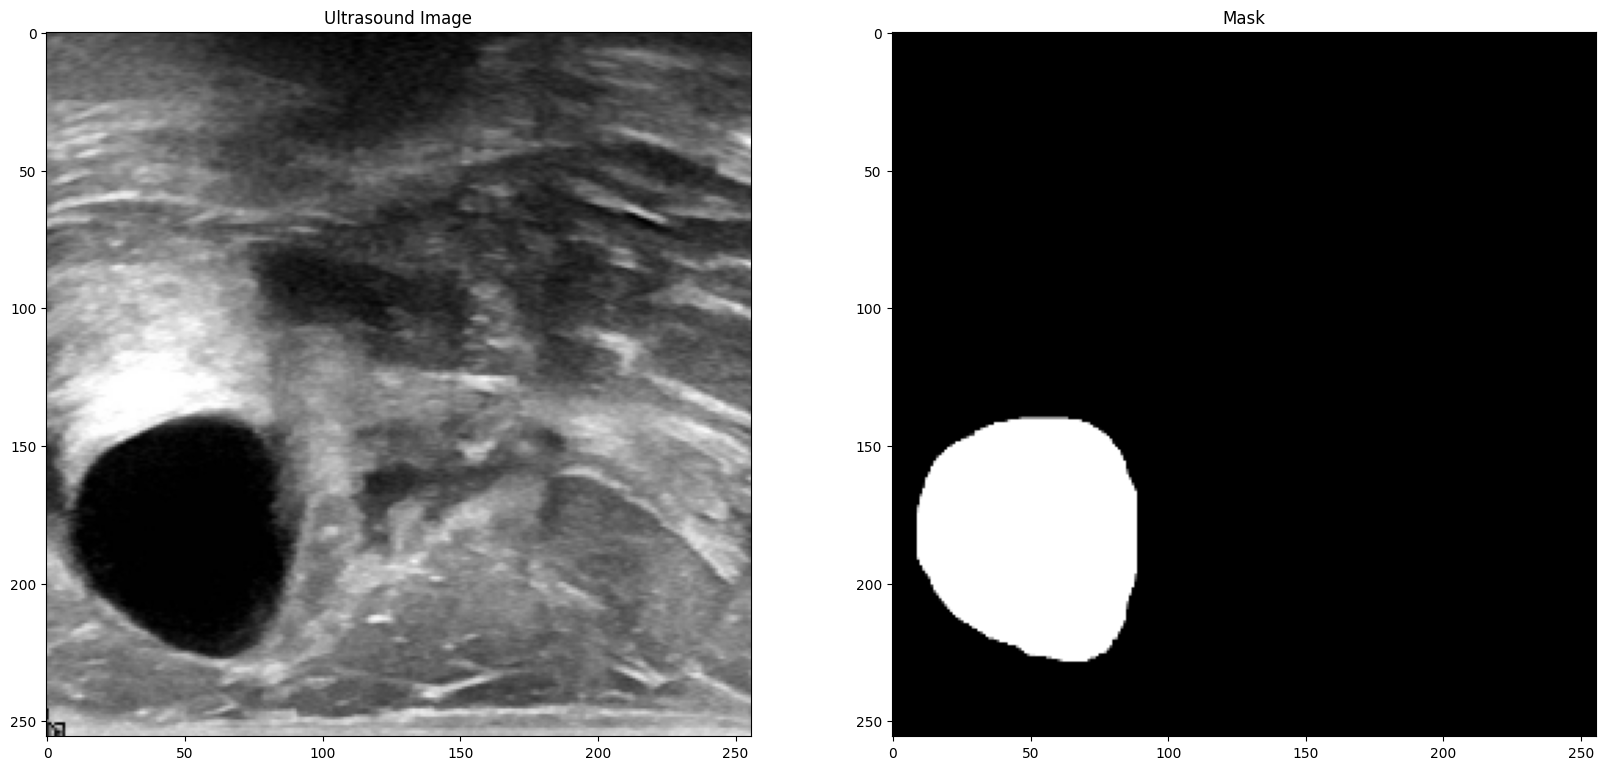

In [5]:
# Display one image/mask pair from the loaded dataset
plt.figure(figsize=(20, 20))

# Display the ultrasound image
plt.subplot(1, 2, 1)
plt.imshow(train_image_mask['images'][0])
plt.title('Ultrasound Image')

# Display the corresponding mask
plt.subplot(1, 2, 2)
plt.imshow(train_image_mask['masks'][0], cmap='gray')
plt.title('Mask')

plt.show()

## U-Net building blocks
Create the building blocks for constructing the U-Net model. The key component of U-Net is its ***convolutional blocks***, which enable the network to extract spatial features from input images and generate detailed segmentation maps. These convolutional blocks consist of several layers and operations that work together to capture hierarchical features from the input data.
* Convolution Layer (Conv):
This layer applies convolutional filters (kernels) to the input image to extract low-level features such as edges, textures, and shapes. Each convolutional layer in U-Net uses small 
3×3 filters, which allows the model to capture fine-grained features while maintaining spatial resolution. These filters are applied in a sliding window manner across the input image.
* Batch Normalization:
Batch normalization normalizes the output of the previous layer to have a mean of zero and a standard deviation of one. This can help stabilize and speed up the training process by reducing internal covariate shift and making the model more robust to different input variations.
* Activation Function (ReLU):
At the end, an activation function, typically the ReLU (Rectified Linear Unit) function, is applied element-wise to the output. ReLU introduces non-linearity to the model, allowing it to learn more complex patterns and relationships in the data. It also helps mitigate the vanishing gradient problem and speeds up convergence during training.

These 3 operations are repeated twice in a *convo_block*


In [6]:
# Define building blocks
def convo_block(inputTensor, out_channels, kernelSize = 3):
    convo_block = Conv2D(filters = out_channels, kernel_size = (kernelSize, kernelSize), kernel_initializer = 'he_normal', padding = 'same')(inputTensor)
    convo_block = BatchNormalization()(convo_block)
    convo_block = Activation('relu')(convo_block)

    convo_block = Conv2D(filters = out_channels, kernel_size = (kernelSize, kernelSize), kernel_initializer = 'he_normal', padding = 'same')(convo_block)
    convo_block = BatchNormalization()(convo_block)
    convo_block = Activation('relu')(convo_block)

    return convo_block

### Build the U-Net model

In [7]:

# Definition of the entire U-Net architecture
def modelArchitecture(inputTensor, final_out_channels = 1, first_out_channel=64, dropoutRate = 0.1):
    # Initialization of the encoder
    down_b1 = convo_block(inputTensor, first_out_channel)
    down_b1_layer = MaxPooling2D((2, 2),strides=(2, 2))(down_b1)
    down_b1_layer = Dropout(dropoutRate)(down_b1_layer)

    down_b2 = convo_block(down_b1_layer, first_out_channel*2)
    down_b2_layer = MaxPooling2D((2, 2),strides=(2, 2))(down_b2)
    down_b2_layer = Dropout(dropoutRate)(down_b2_layer)

    down_b3 = convo_block(down_b2_layer, first_out_channel*4)
    down_b3_layer = MaxPooling2D((2, 2),strides=(2, 2))(down_b3)
    down_b3_layer = Dropout(dropoutRate)(down_b3_layer)

    down_b4 = convo_block(down_b3_layer, first_out_channel*8)
    down_b4_layer = MaxPooling2D((2, 2),strides=(2, 2))(down_b4)
    down_b4_layer = Dropout(dropoutRate)(down_b4_layer)

    down_b5 = convo_block(down_b4_layer, first_out_channel*16)
    #down_b5 = MaxPooling2D((2, 2),stride=2)(down_b5)
    #down_b5 = Dropout(dropoutRate)(down_b5)


    # Initialization of the decoder
    up_deconv1 = Conv2DTranspose(first_out_channel*8, (3, 3), strides = (2, 2), padding = 'same')(down_b5)
    skip_connection1 = concatenate([up_deconv1, down_b4])
    skip_connection1 = Dropout(dropoutRate)(skip_connection1)
    up_b1 = convo_block(skip_connection1, first_out_channel*8)

    up_deconv2 = Conv2DTranspose(first_out_channel*4, (3, 3), strides = (2, 2), padding = 'same')(up_b1)
    skip_connection2 = concatenate([up_deconv2, down_b3])
    skip_connection2 = Dropout(dropoutRate)(skip_connection2)
    up_b2 = convo_block(skip_connection2, first_out_channel*4)

    up_deconv3 = Conv2DTranspose(first_out_channel*2, (3, 3), strides = (2, 2), padding = 'same')(up_b2)
    skip_connection3 = concatenate([up_deconv3, down_b2])
    skip_connection3 = Dropout(dropoutRate)(skip_connection3)
    up_b3 = convo_block(skip_connection3, first_out_channel*2)

    up_deconv4 = Conv2DTranspose(first_out_channel, (3, 3), strides = (2, 2), padding = 'same')(up_b3)
    skip_connection4 = concatenate([up_deconv4, down_b1])
    skip_connection4 = Dropout(dropoutRate)(skip_connection4)
    up_b4 = convo_block(skip_connection4, first_out_channel)

    out = Conv2D(final_out_channels, (1, 1), activation = 'sigmoid')(up_b4)

    segmentationModel = Model(inputs = [inputTensor], outputs = [out])

    return segmentationModel

In [8]:
# Initialization of the segmentation model
inputs = Input((256, 256, 3))

segmentationModel = modelArchitecture(inputs, dropoutRate = 0.1)
segmentationModel.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy',MeanIoU(num_classes=2,name='IoU')])
segmentationModel.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_1[

 Total params: 34,536,897 (131.75 MB)

 Trainable params: 34,525,121 (131.70 MB)

 Non-trainable params: 11,776 (46.00 KB)

## Compile and train the model

In [9]:
history = segmentationModel.fit(
    np.array(train_image_mask['images']), 
    np.array(train_image_mask['masks']),
    epochs=50,
    batch_size=16,
    validation_data=(
        np.array(valid_image_mask['images']), 
        np.array(valid_image_mask['masks'])
    ),
    callbacks=[
        EarlyStopping(
            patience=15, 
            monitor='val_loss', 
            mode='min', 
            restore_best_weights=True, 
            verbose=1
        )
    ]
)


Epoch 1/50


I0000 00:00:1757493859.685528     105 service.cc:145] XLA service 0x7b9aa40014d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757493859.685582     105 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757493909.723558     105 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1757493909.764667     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


129/129 ━━━━━━━━━━━━━━━━━━━━ 162s 787ms/step - IoU: 0.3748 - accuracy: 0.8540 - loss: 0.3801 - val_IoU: 0.4604 - val_accuracy: 0.8052 - val_loss: 0.4583
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 57s 445ms/step - IoU: 0.3784 - accuracy: 0.9203 - loss: 0.2328 - val_IoU: 0.5120 - val_accuracy: 0.4188 - val_loss: 2.5040
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 57s 445ms/step - IoU: 0.3746 - accuracy: 0.9275 - loss: 0.2021 - val_IoU: 0.4517 - val_accuracy: 0.7317 - val_loss: 0.5920
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 57s 445ms/step - IoU: 0.3757 - accuracy: 0.9323 - loss: 0.1880 - val_IoU: 0.4637 - val_accuracy: 0.8158 - val_loss: 0.5458
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 58s 446ms/step - IoU: 0.3748 - accuracy: 0.9357 - loss: 0.1748 - val_IoU: 0.4534 - val_accuracy: 0.9087 - val_loss: 0.2463
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 58s 446ms/step - IoU: 0.3730 - accuracy: 0.9372 - loss: 0.1700 - val_IoU: 0.4516 - val_accuracy: 0.9366 - val_loss: 0.1906
Epoch 7/50
129/129 ━━━━━━━━━━━━━

## Plot the loss and accuracy curves from model history

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

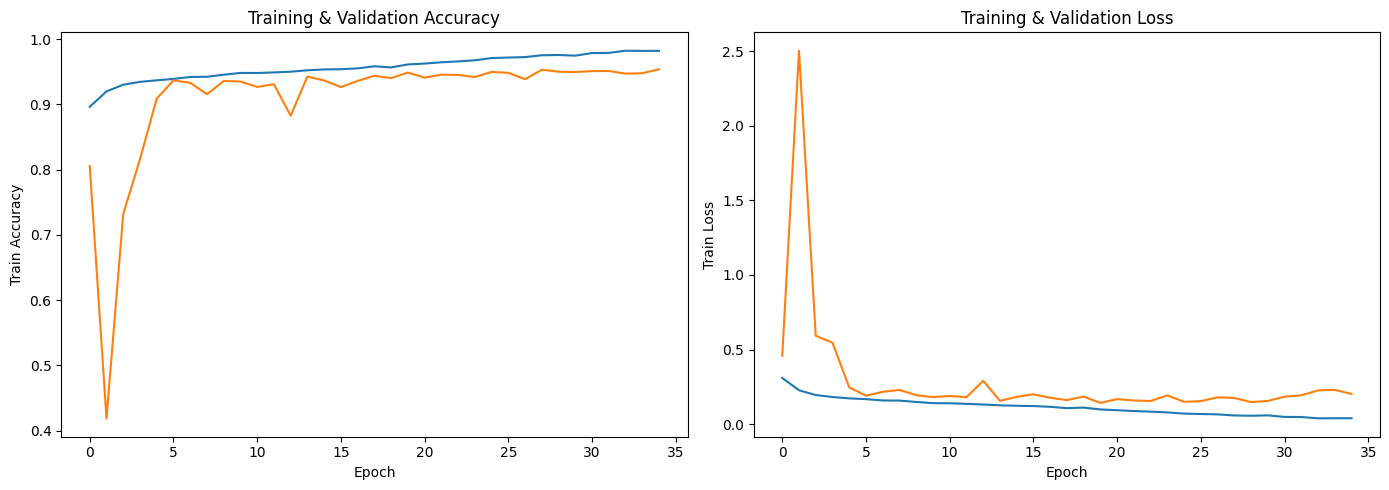

In [10]:
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(len(train_accuracy))

# Convert accuracy and loss to a DataFrame for easier plotting with Seaborn
history_df = pd.DataFrame({
    'Epoch': epochs,
    'Train Accuracy': train_accuracy,
    'Train Loss': train_loss,
    'Validation Accuracy': val_accuracy,
    'Validation Loss': val_loss
})

# Create subplots to place the plots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot training accuracy using Seaborn
sns.lineplot(data=history_df, x='Epoch', y='Train Accuracy', ax=axes[0])
sns.lineplot(data=history_df, x='Epoch', y='Validation Accuracy', ax=axes[0])
axes[0].set_title('Training & Validation Accuracy')

# Plot training loss using Seaborn
sns.lineplot(data=history_df, x='Epoch', y='Train Loss', ax=axes[1])
sns.lineplot(data=history_df, x='Epoch', y='Validation Loss', ax=axes[1])
axes[1].set_title('Training & Validation Loss')

# Display and save the plots
plt.savefig("loss&accuracy.png")
plt.tight_layout()
plt.show()


In [11]:
testImages = test_image_mask['images']
testMasks = test_image_mask['masks']

predictions = segmentationModel.predict(np.array(testImages))
print(predictions.shape)

test_IoU = tf.keras.metrics.MeanIoU(num_classes=2)
test_IoU.update_state(testMasks, predictions)
print(f"Test IoU: {test_IoU.result().numpy()}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 38s 814ms/step
(588, 256, 256, 1)
Test IoU: 0.4158684015274048


## Predictions with the trained model

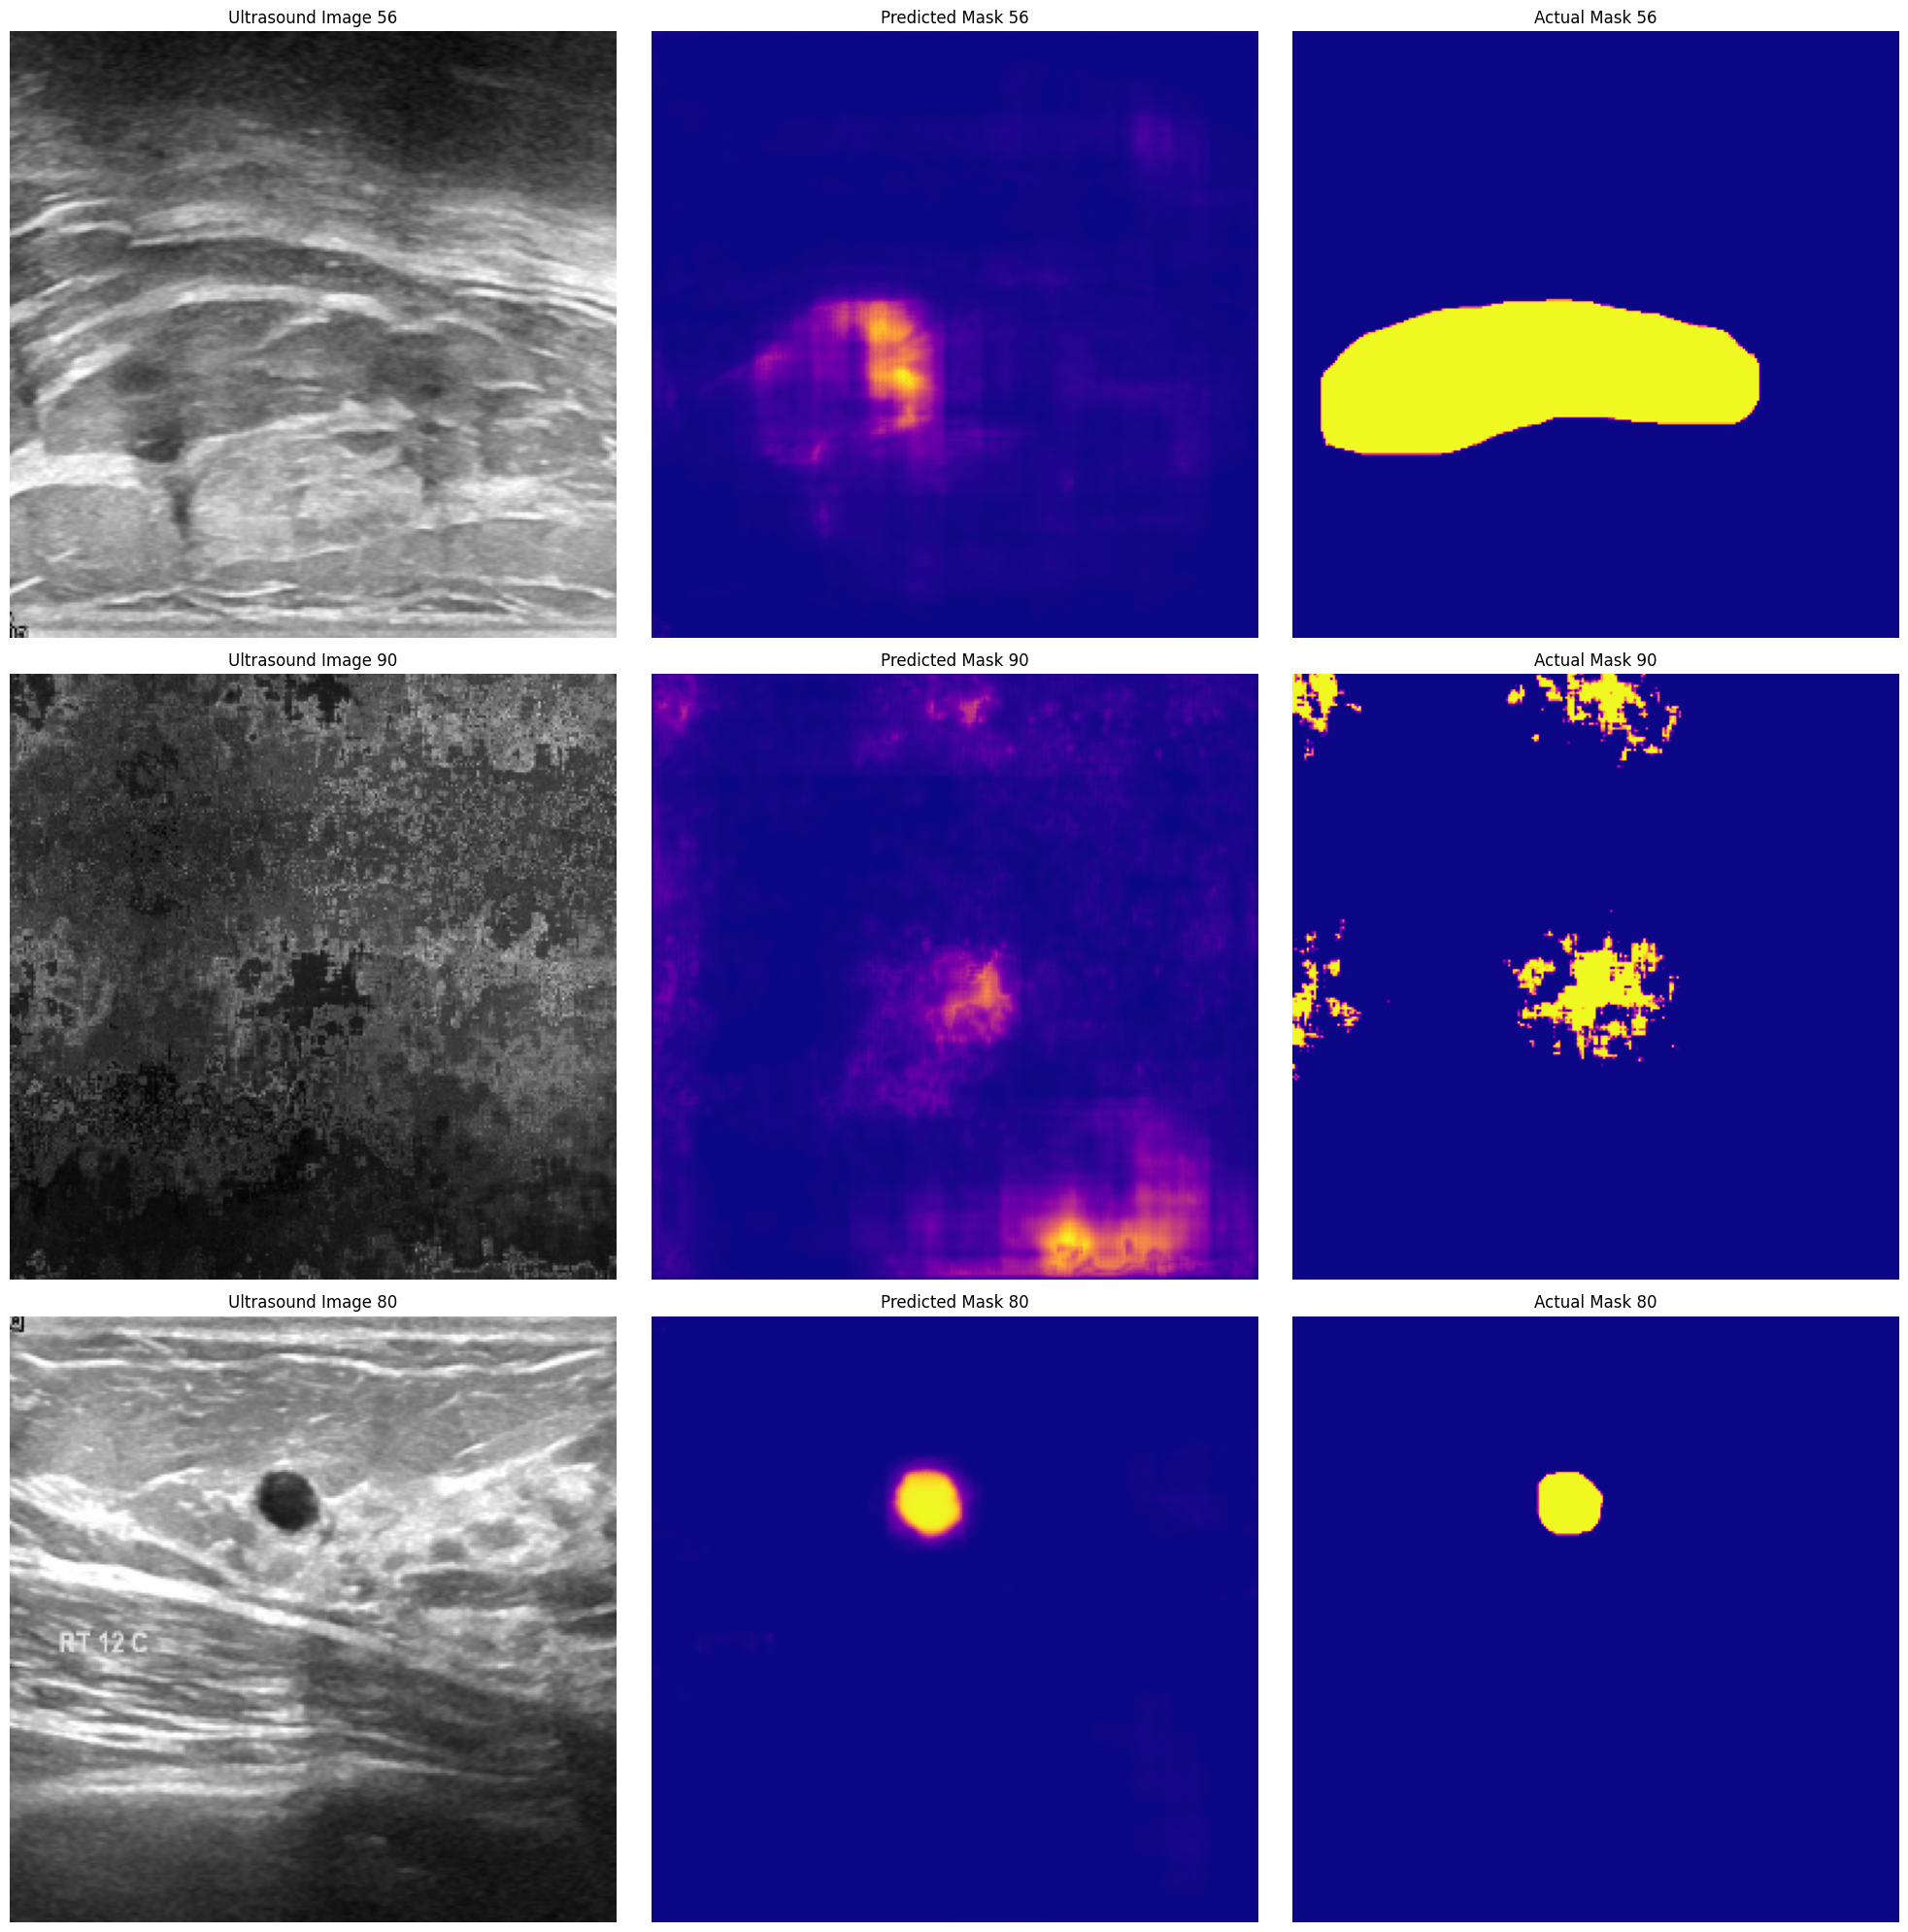

In [12]:
import matplotlib.pyplot as plt

# Define the indices for the images you want to plot
indices = [56, 90, 80]  # Modify these indices as needed

# Initialize the figure with a 3x3 grid
plt.figure(figsize=(20, 20))

# Loop over the indices and create subplots
for i, idx in enumerate(indices):
    # Determine the row and column for each image
    row = i // 3  # Row index (0 for the first row, 1 for the second row, etc.)
    col = i % 3   # Column index (0 for the first column, 1 for the second column, etc.)
    
    # Plot Ultrasound Image
    plt.subplot(3, 3, 3*i + 1)
    plt.imshow(testImages[idx])
    plt.title(f'Ultrasound Image {idx}')
    plt.axis('off')
    
    # Plot Predicted Mask
    plt.subplot(3, 3, 3*i + 2)
    plt.imshow(predictions[idx], cmap='plasma')
    plt.title(f'Predicted Mask {idx}')
    plt.axis('off')
    
    # Plot Actual Mask
    plt.subplot(3, 3, 3*i + 3)
    plt.imshow(testMasks[idx], cmap='plasma')
    plt.title(f'Actual Mask {idx}')
    plt.axis('off')

# Adjust layout and show the figure
plt.savefig("predicted_mask.png")
plt.tight_layout()
plt.show()


In [13]:
segmentationModel.save('Breast Cancer Segmentation.h5')

We tested our model on 2 datasets : The unfiltered images with merged masks, and the augmented images with their masks. Since the number of channels doubles as we move down the contracting path and halves on the expansive path, adjusting this value will affect the entire structure of the model. Thus, we also use it as a parameter to determine the optimal configuration.

1. The results on unfiltered-merged data
* 16 channels
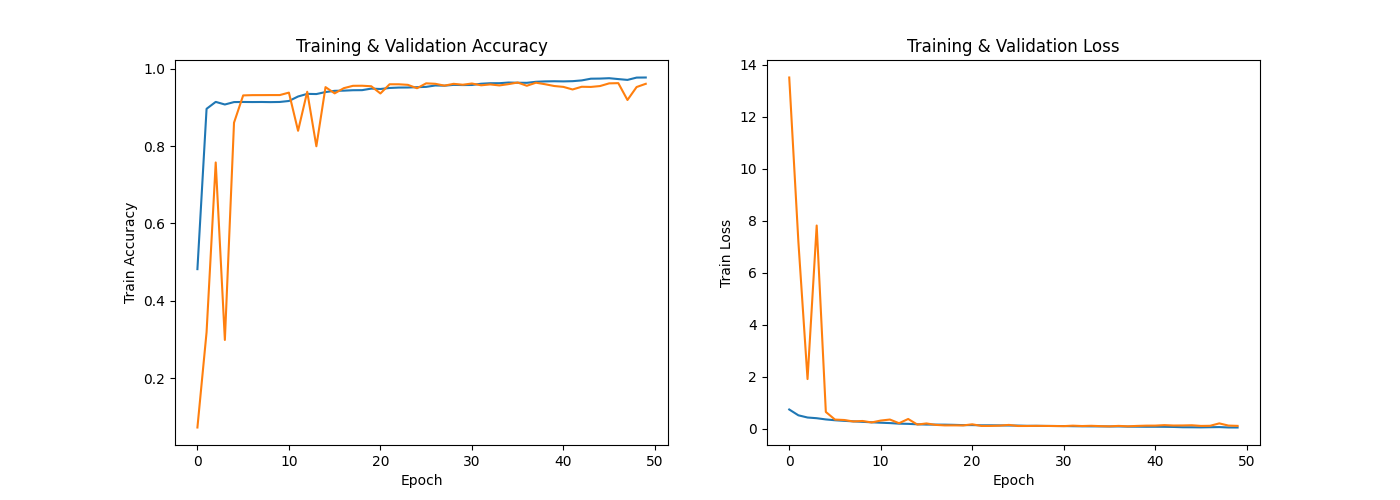
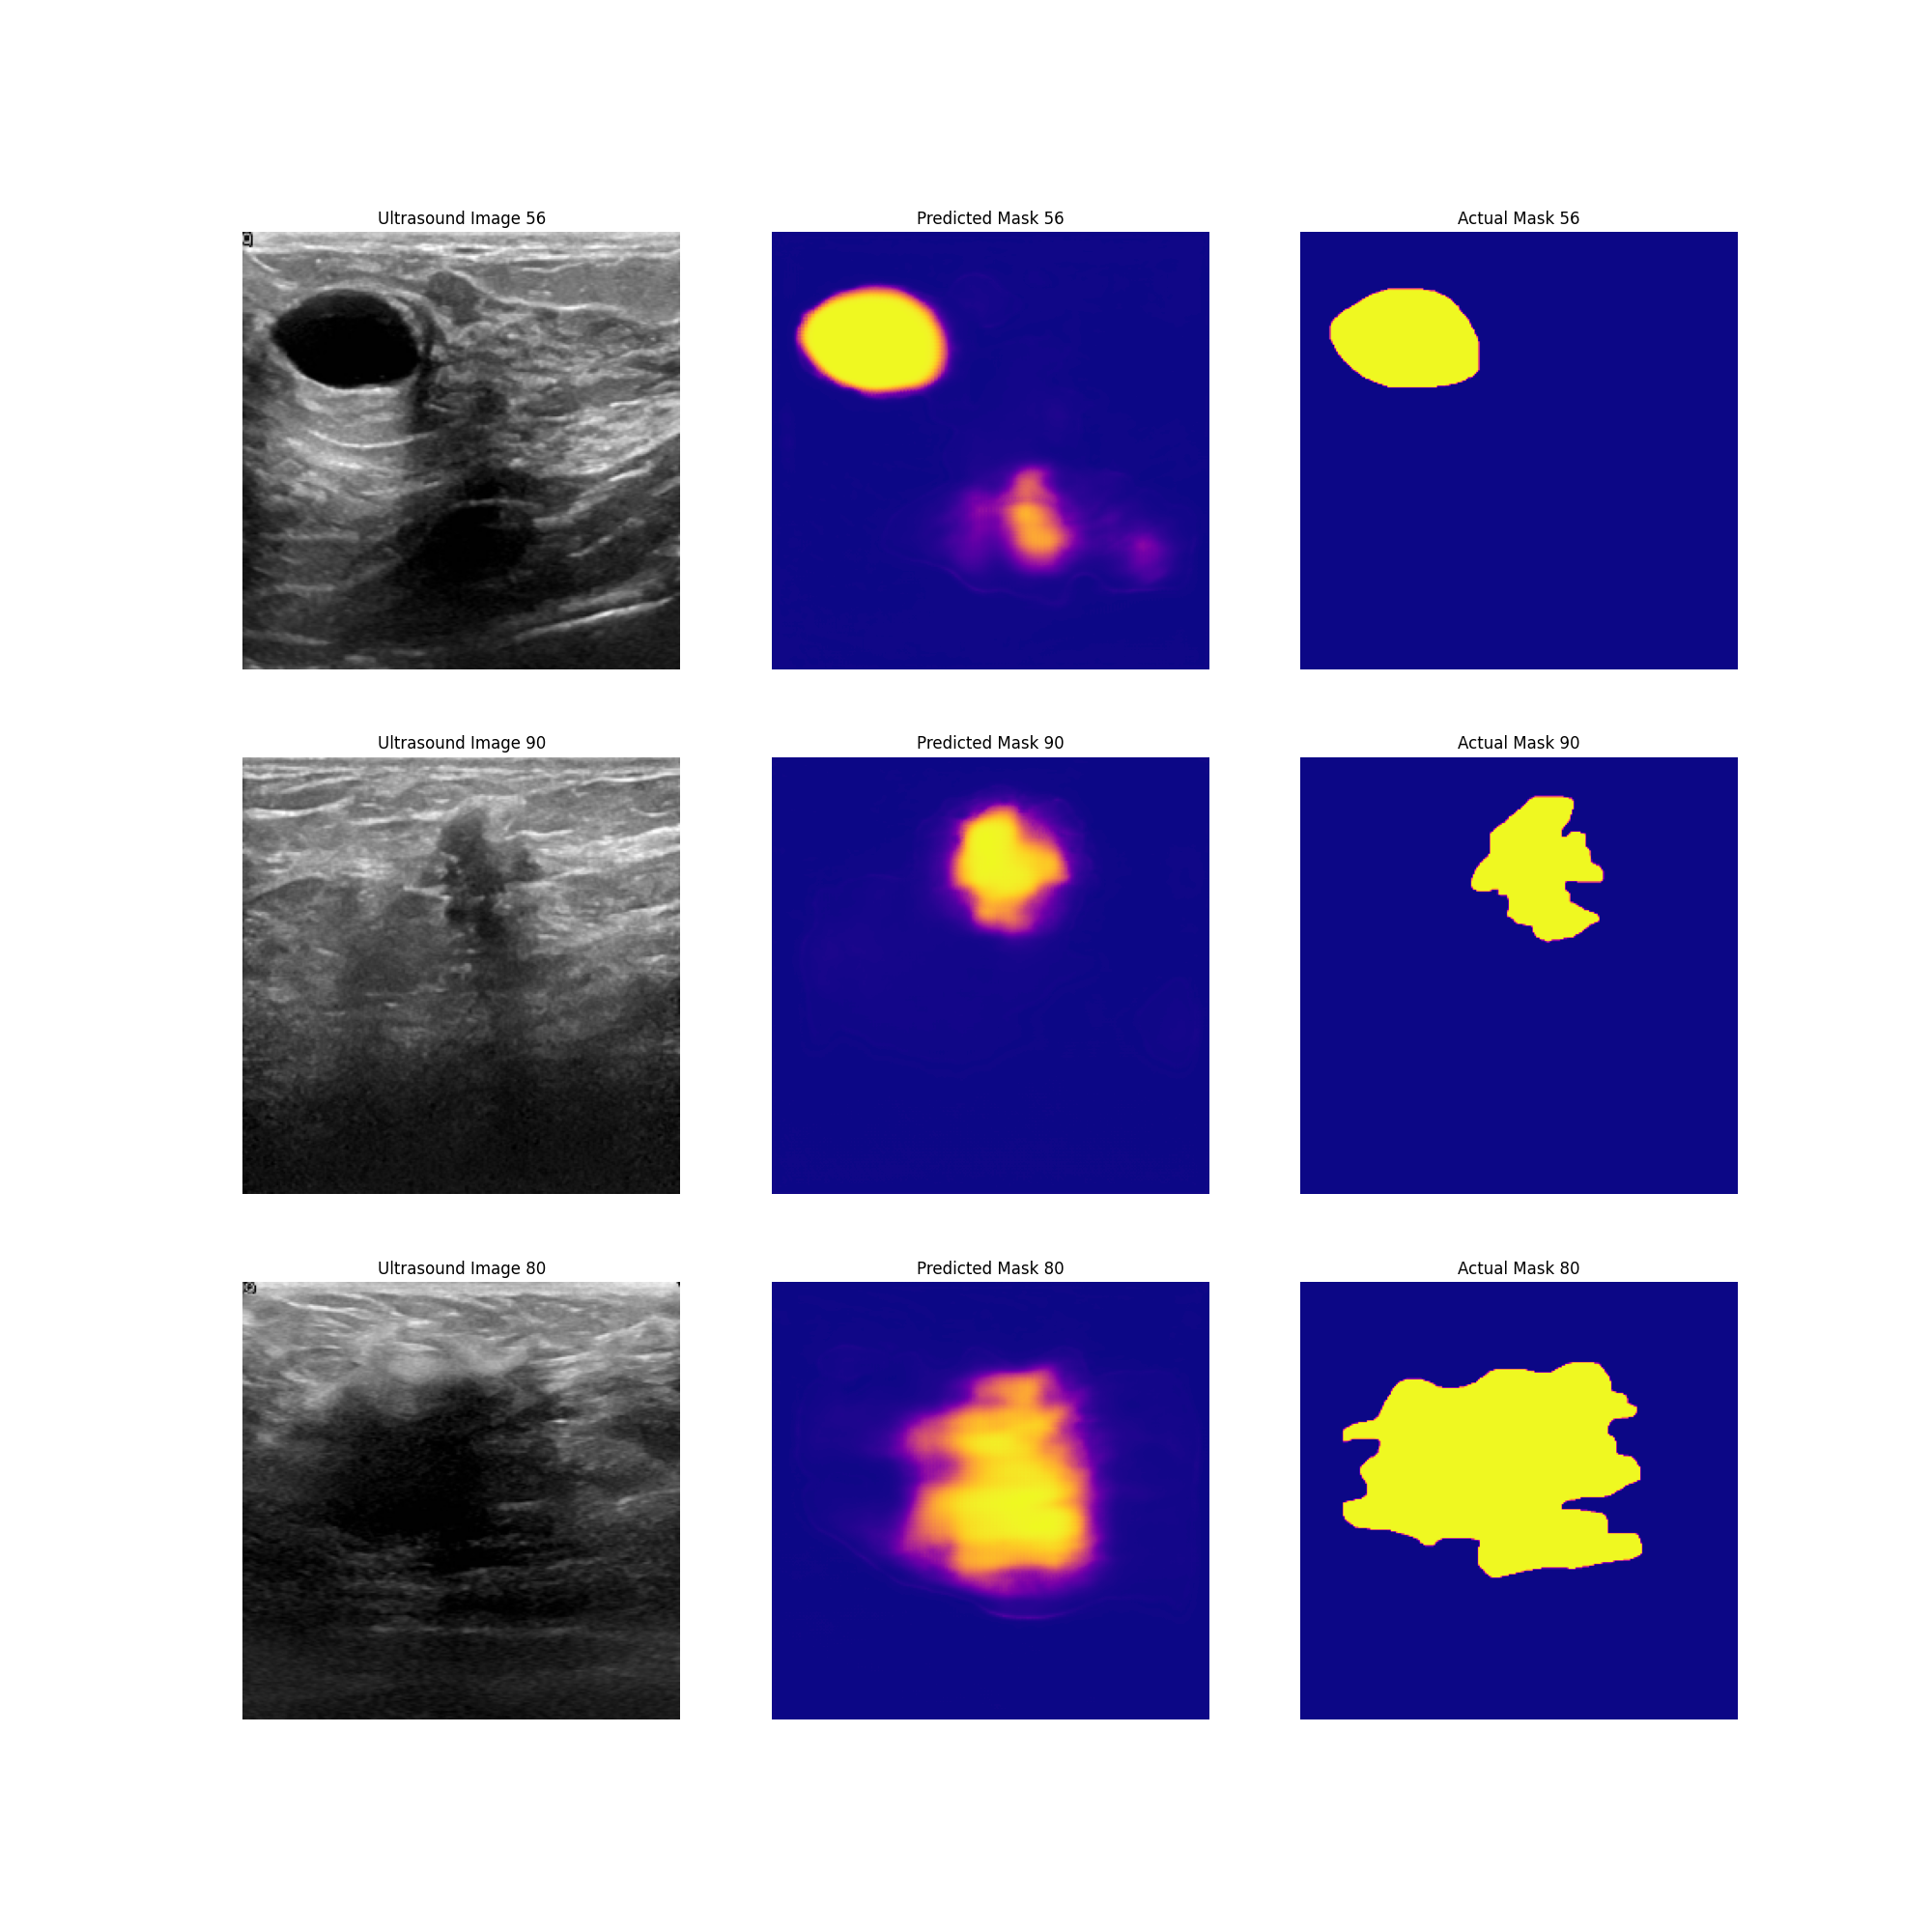

* 32 channels
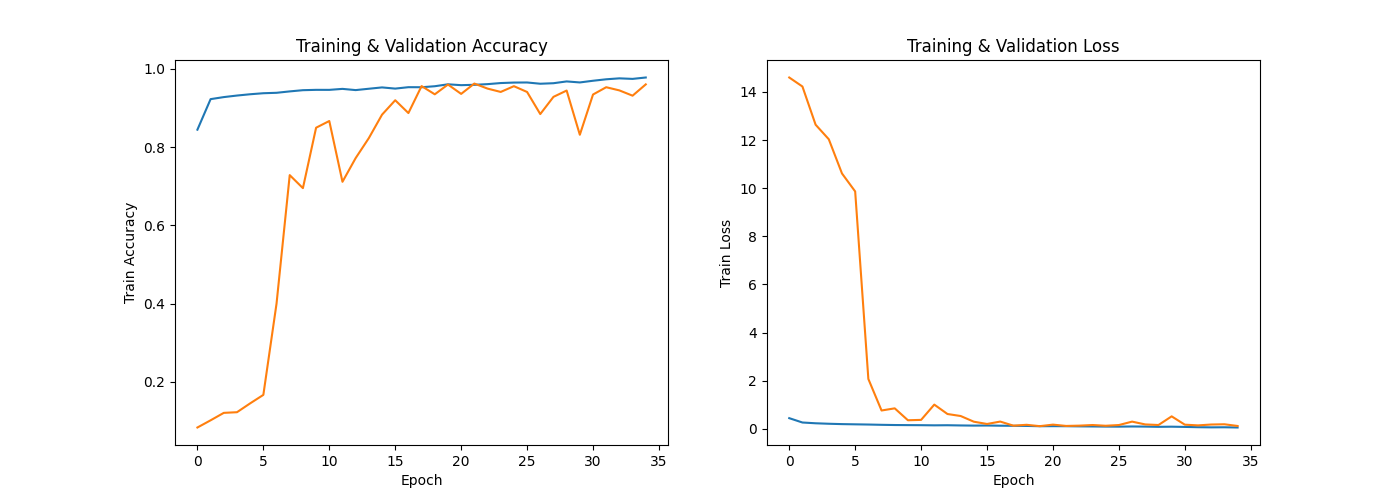
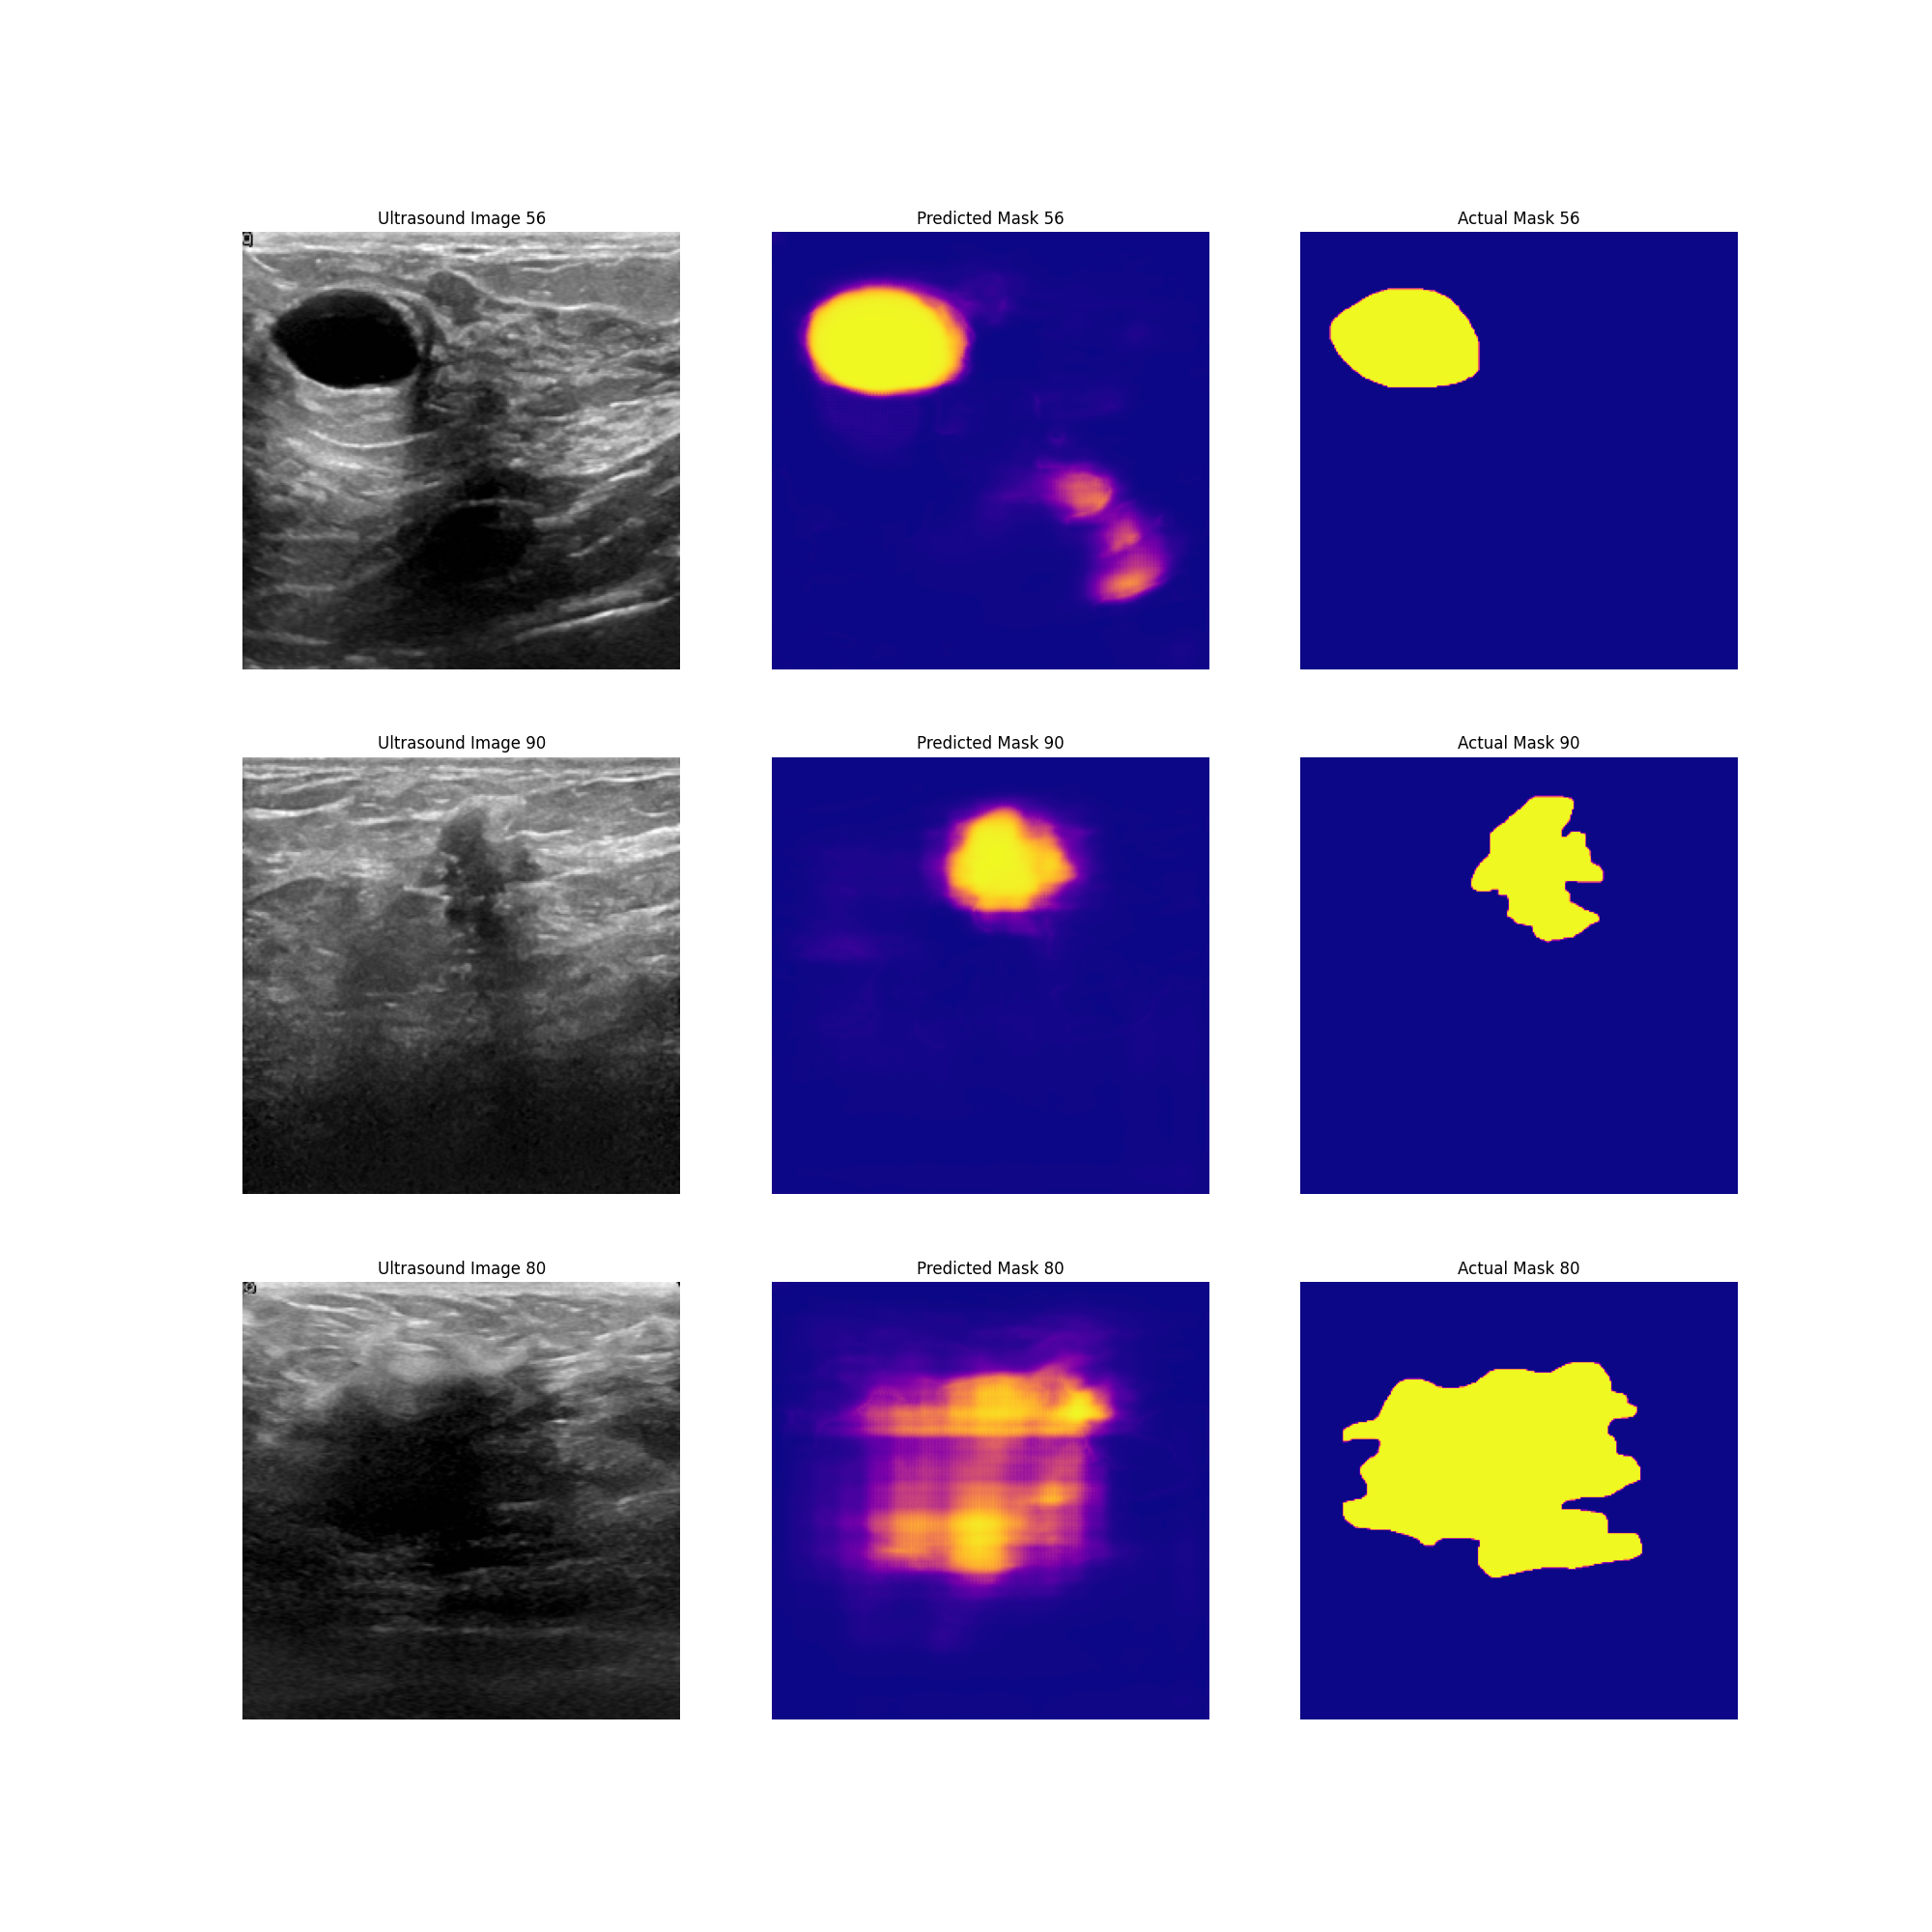

* 64 channels
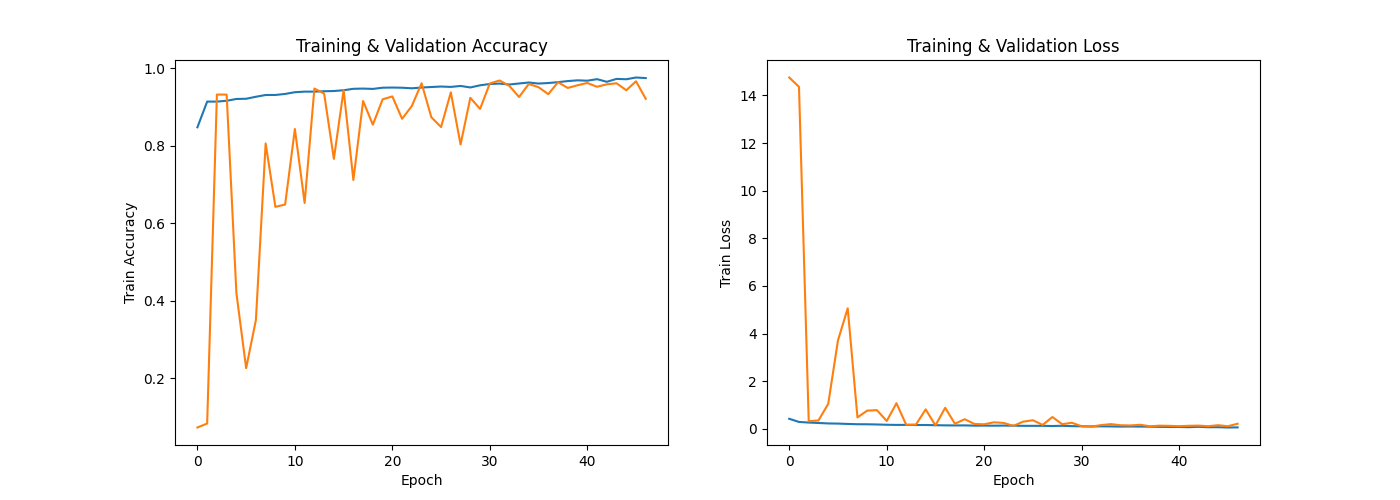
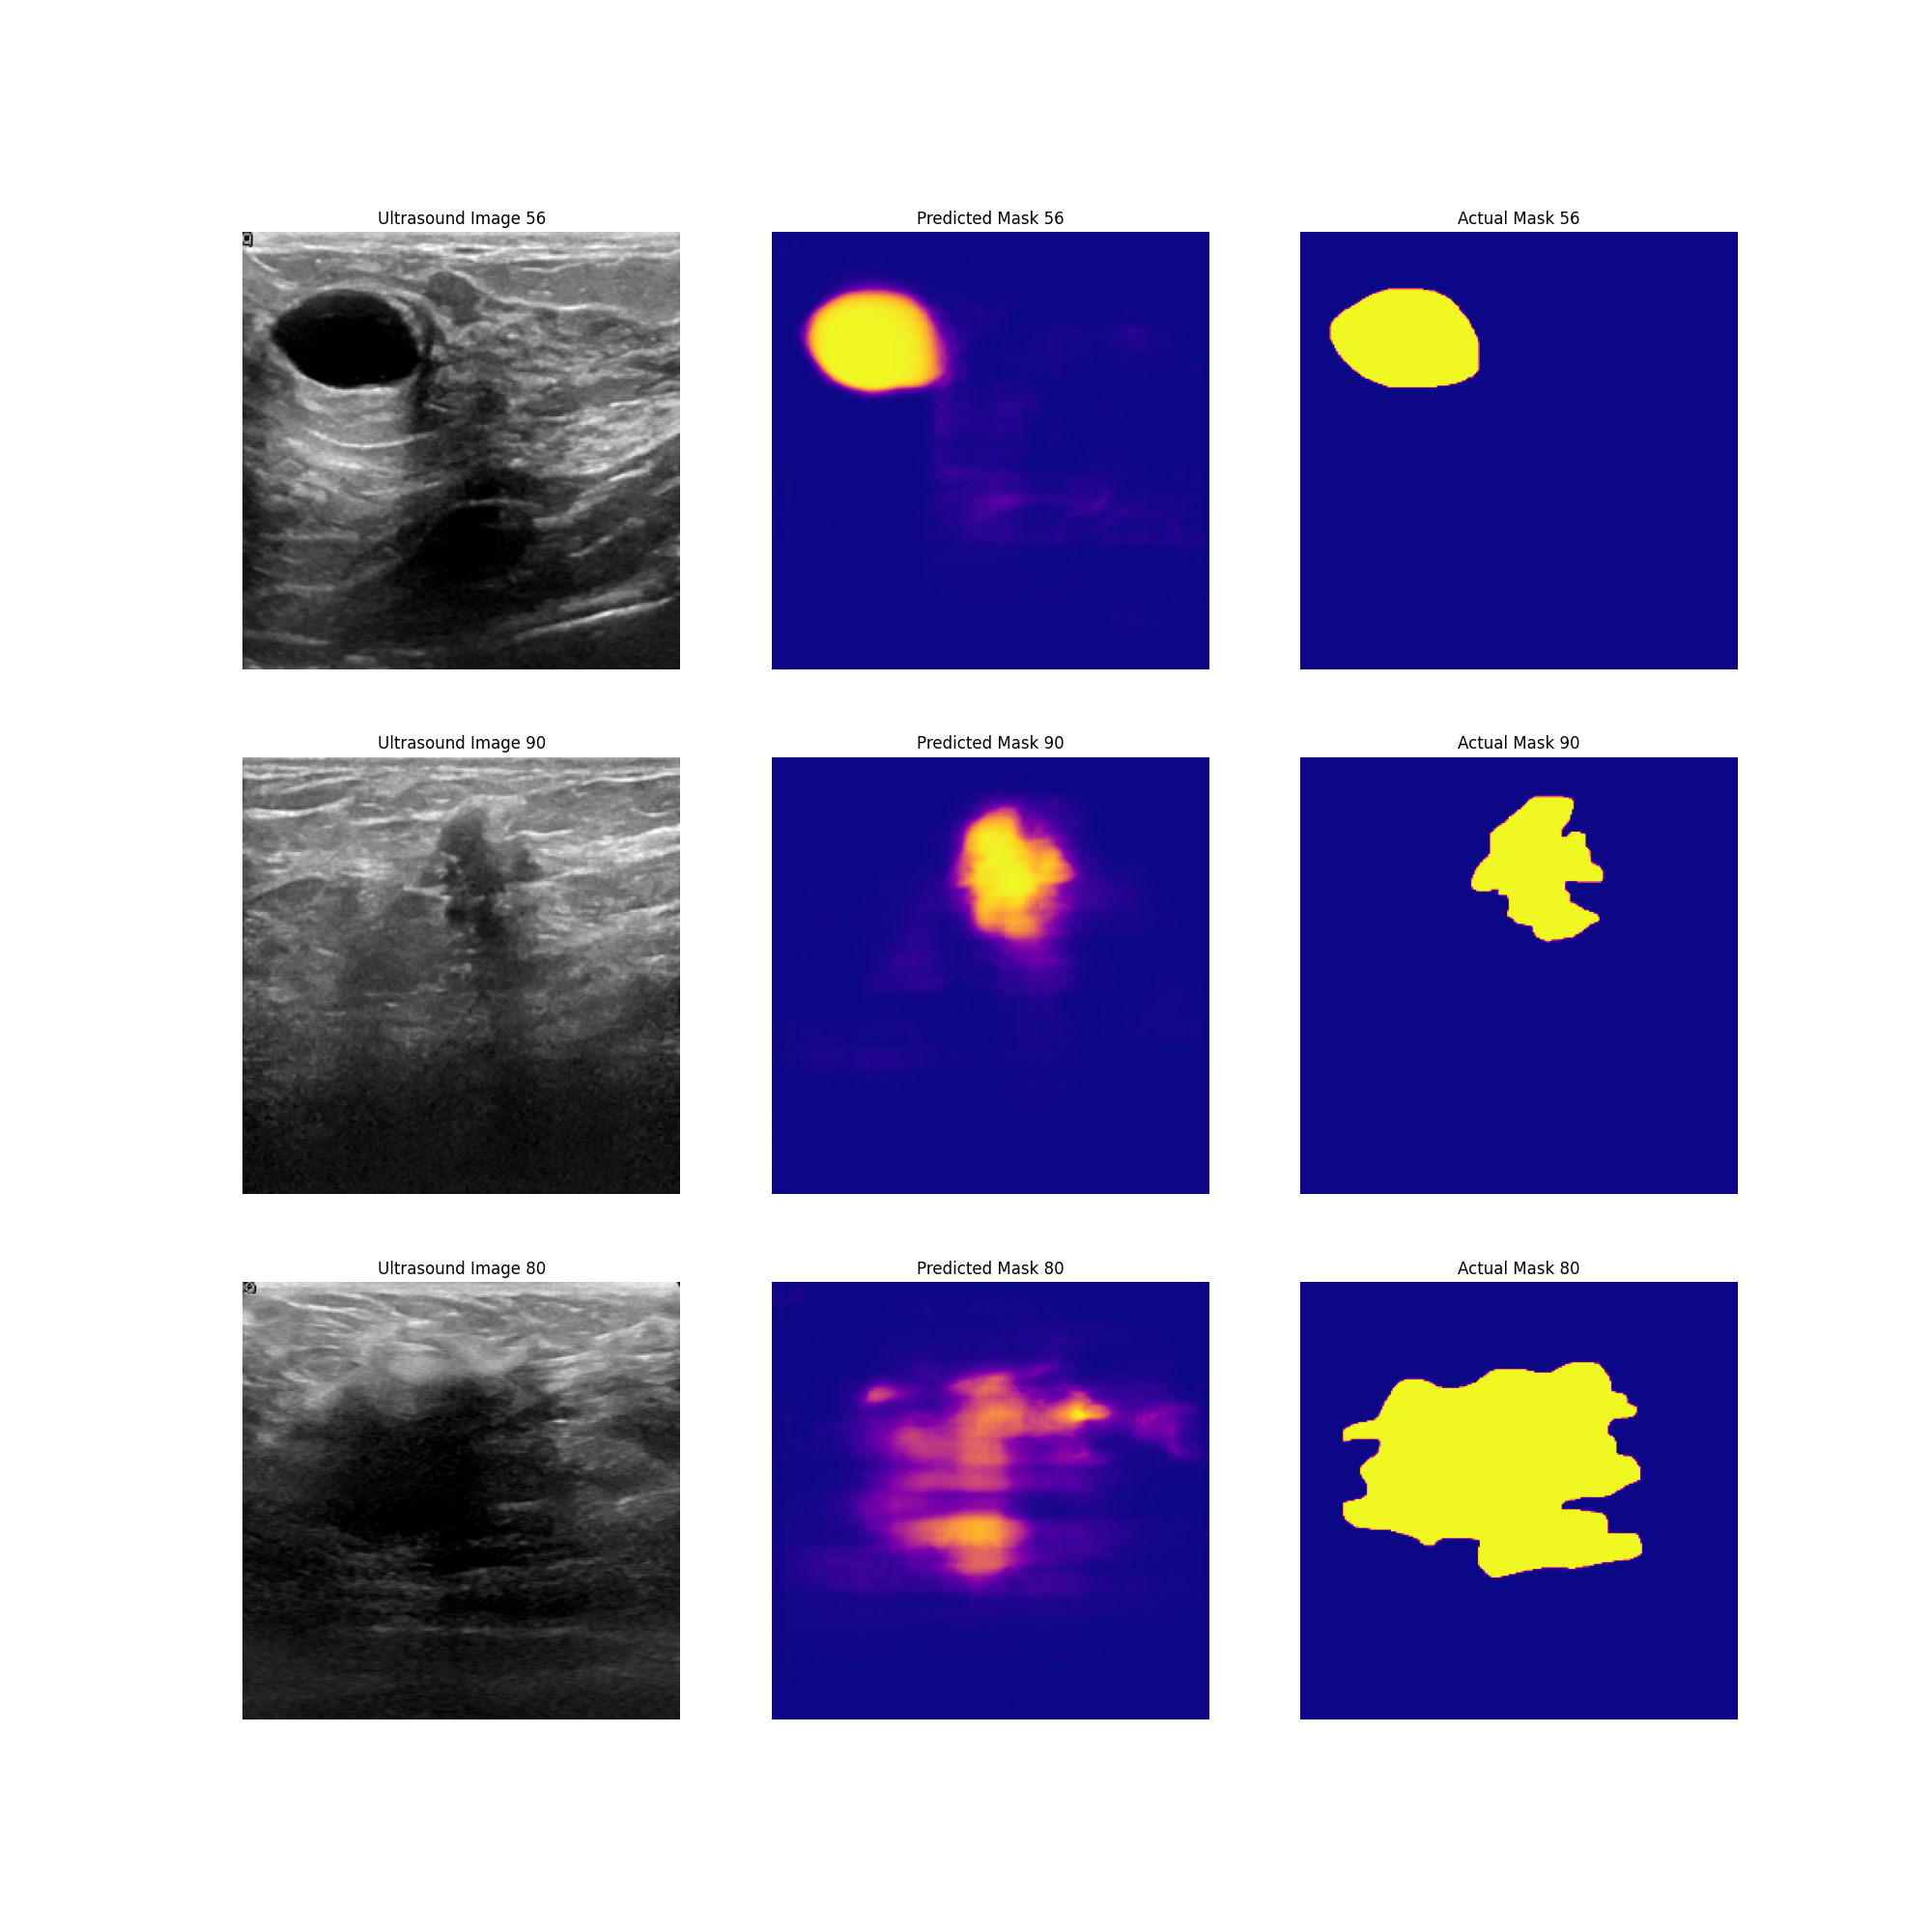

For this dataset, using 32 channels yielded the worst results, while both 16 and 64 channels produced predicted masks that were close to the ground truth. However, the validation accuracy with 64 channels did not increase as steadily over epochs as it did with 16 channels.

2. The augmented data
* 16 channels
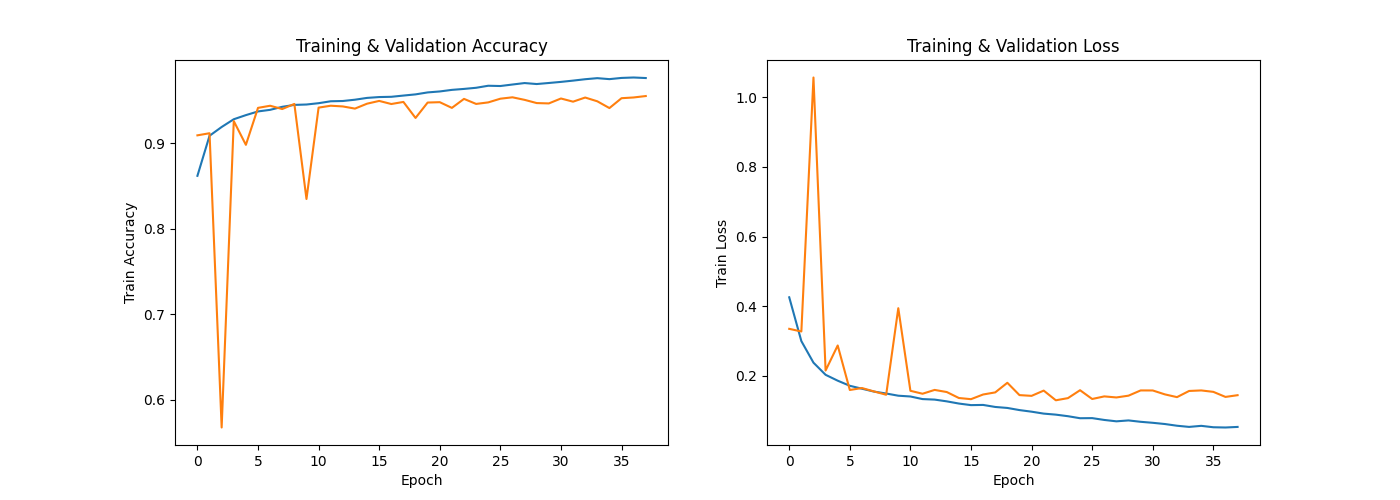
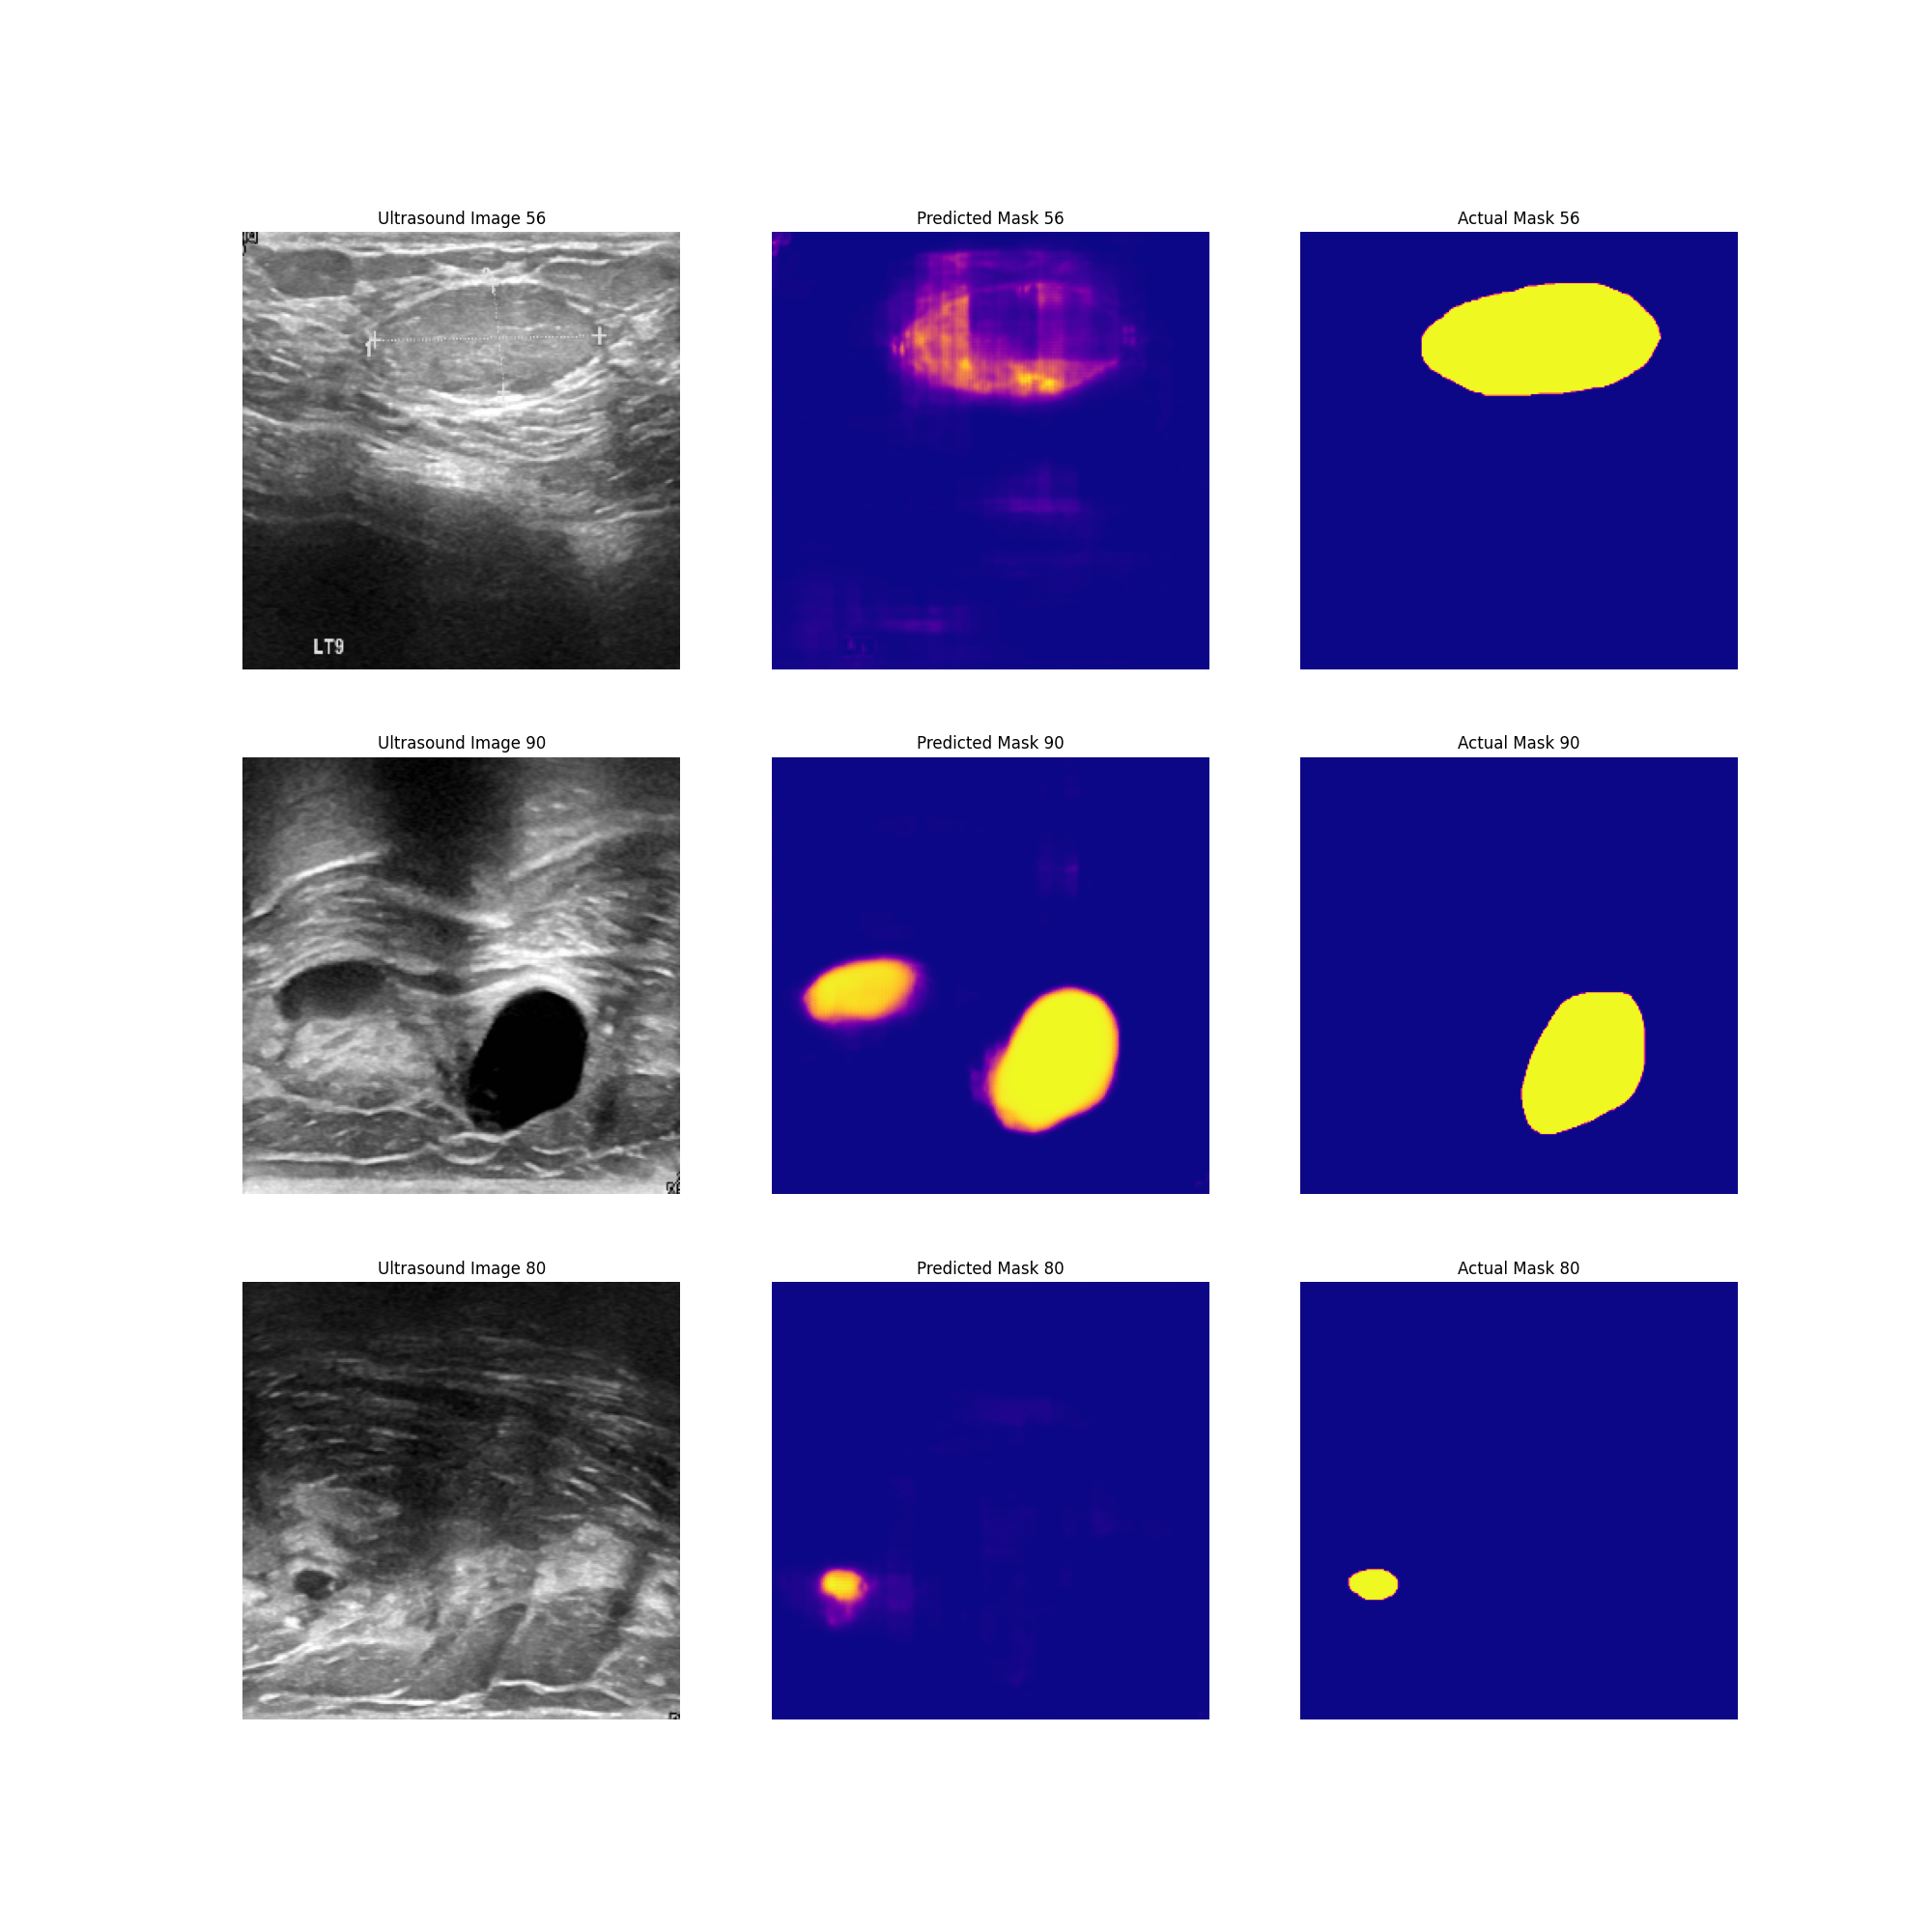

* 32 channels
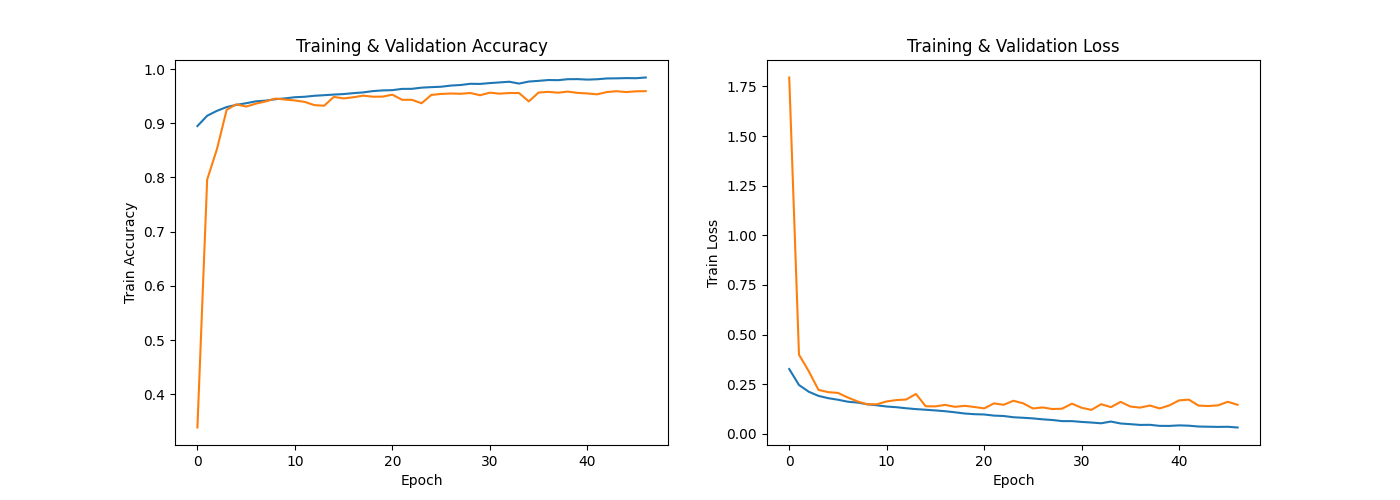
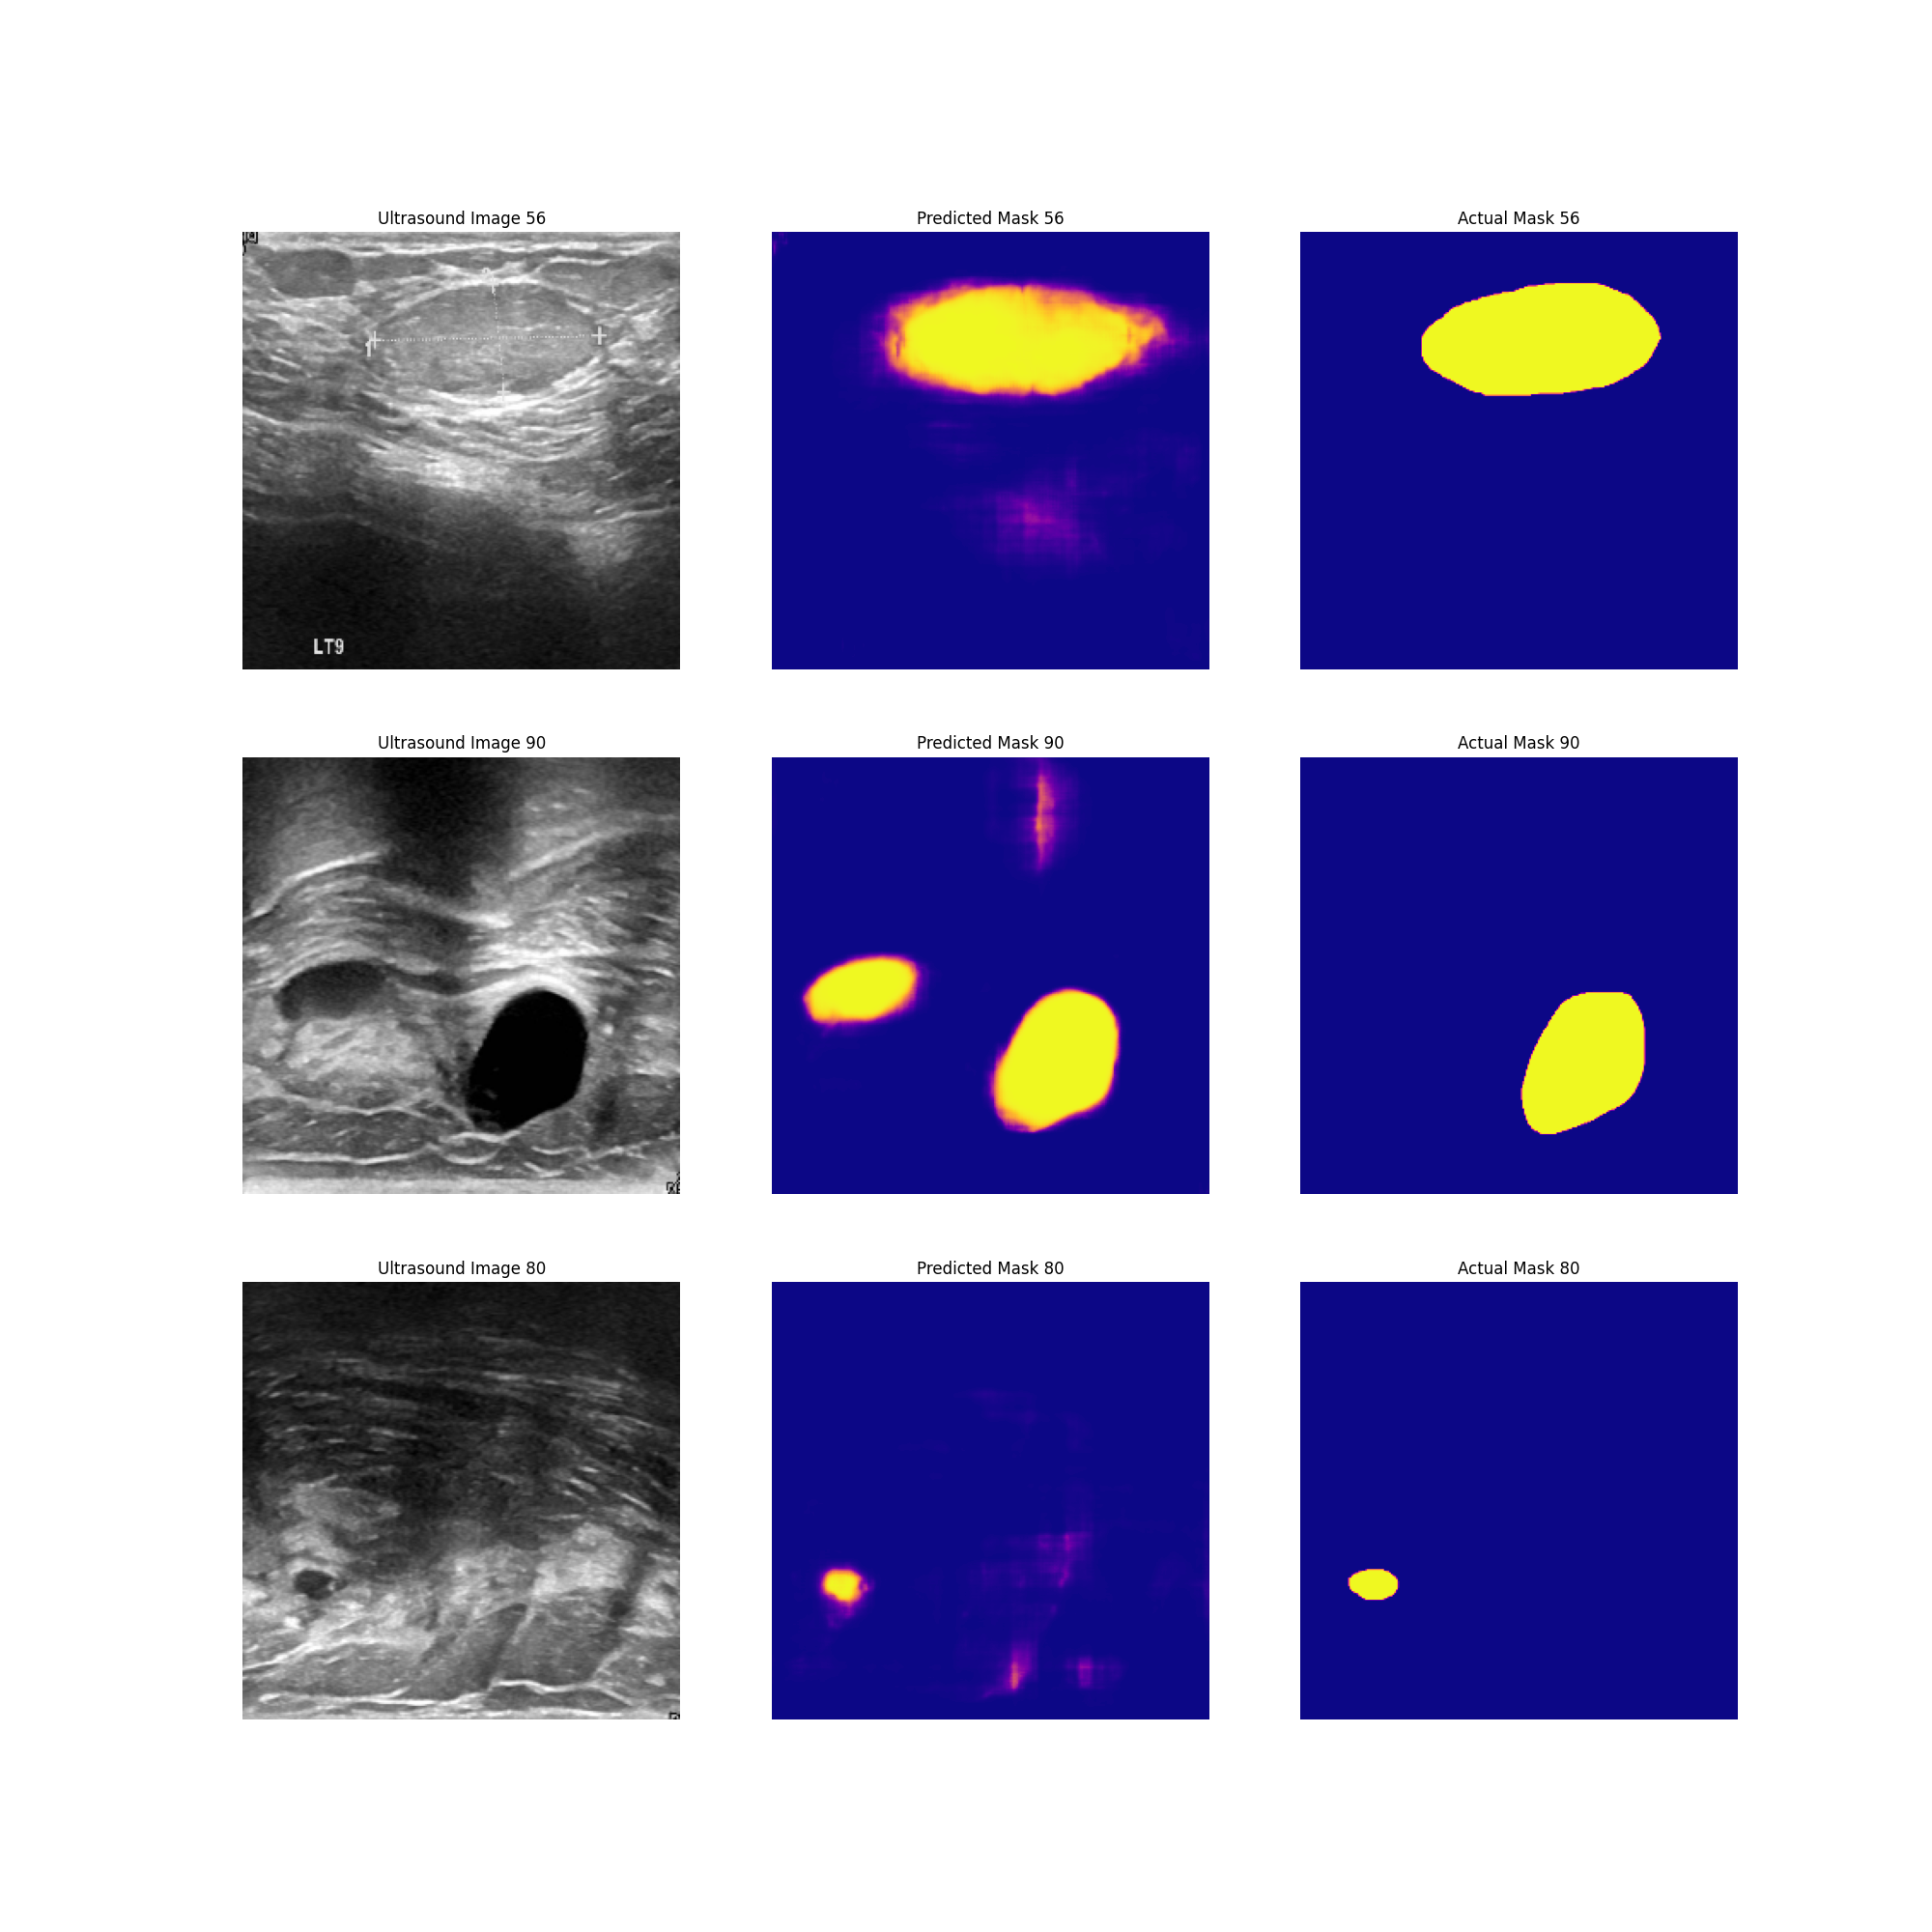

* 64 channels
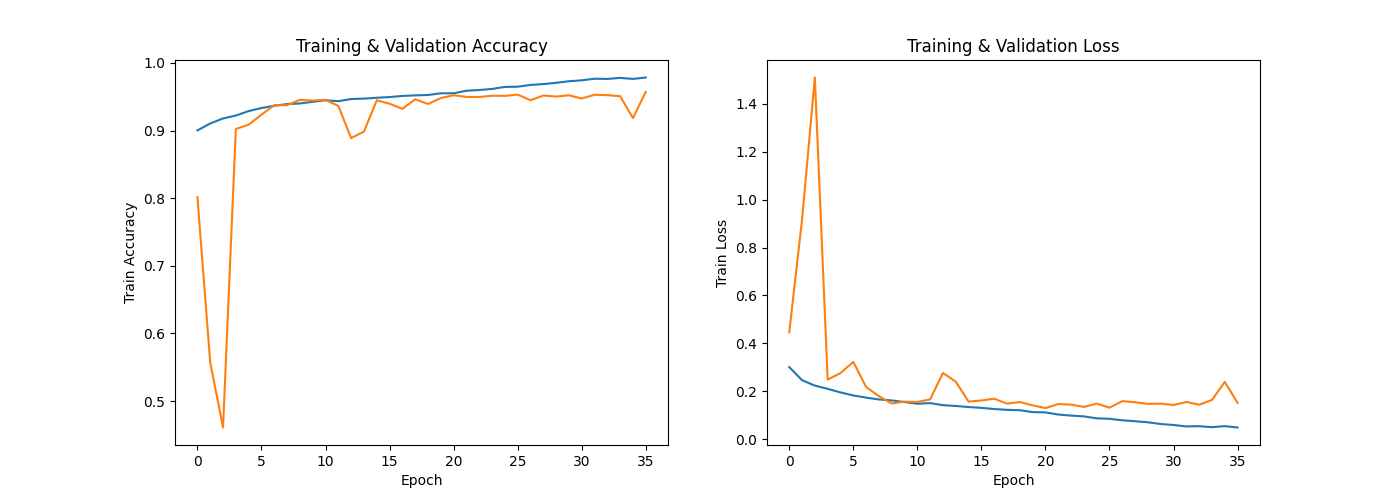
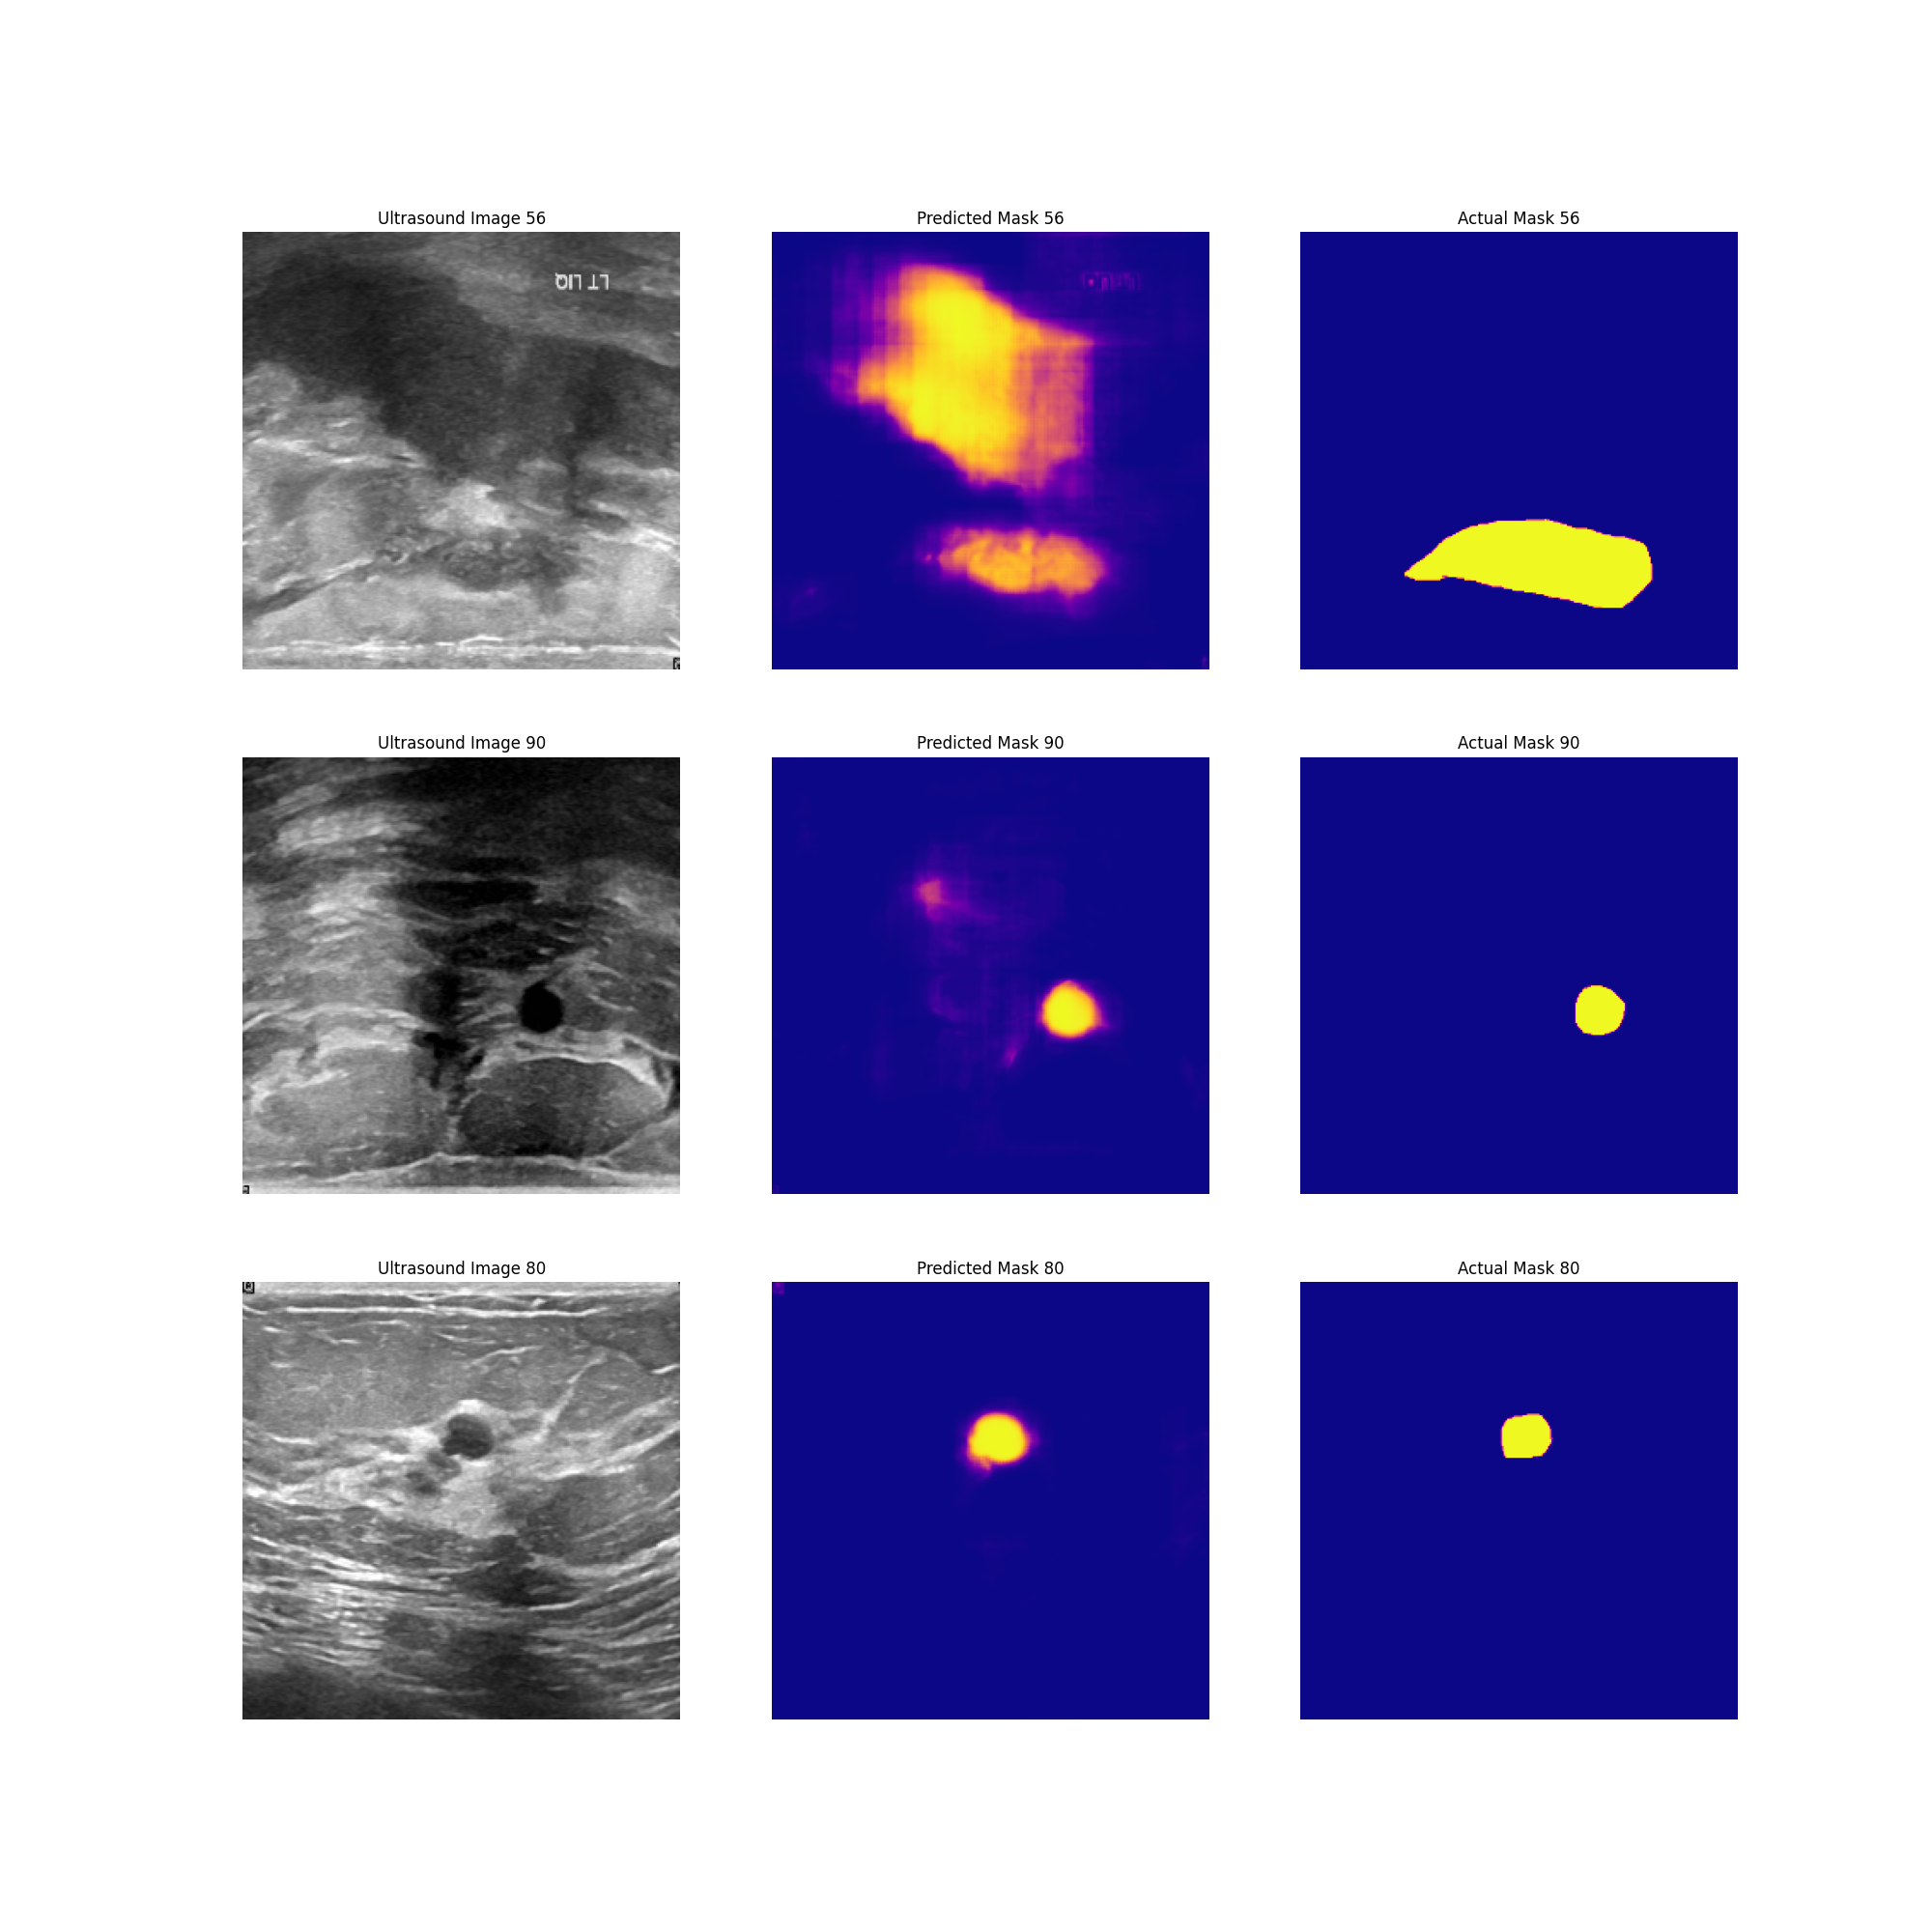

For this dataset, we observed greater stability in both loss and accuracy over epochs compared to the unfiltered merged data. Overall, using 16, 32, and 64 channels produced predicted masks that were close to the ground truth, except in two cases: the second observation with 32 channels, where the left region was incorrectly identified as a tumor, and the first image with 64 channels, where the upper region was misclassified.